# Защита проекта по направлению машинного обучения.
- В данном файле представлено описание проделанной работы. Полностью описать все не получится, поэтому здесь присутсвуют ссылки на файлы [проекта из GitHub](https://github.com/GrishaTS/YaMlProject/). GitHub не всегда отрисовывает картинки при просмотре файлов на сайте, поэтому советую скачать проект.
## Задача проекта:
Представлен датасет из 10 классов (10 цифр) - [SVHN](http://ufldl.stanford.edu/housenumbers/) (The Street View House Numbers). Задачей проекта является классификация цифр, находящихся посередине изображения.

Импорт необходимых библиотек.

In [3]:
import os
import math
import pickle

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import torchvision as tv
from PIL import Image
from livelossplot import PlotLossesKeras

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


----
----
# 1. Предобработка данных и работа с датасетом.

Скачиваем датасет (из 16 картинок для визуализации данных).

In [6]:
protect_ds = pickle.load(open('protect_ds', 'rb'))
protect_ds_x = protect_ds['images']
protect_ds_y = protect_ds['labels']

Изобразим данные без обработки.

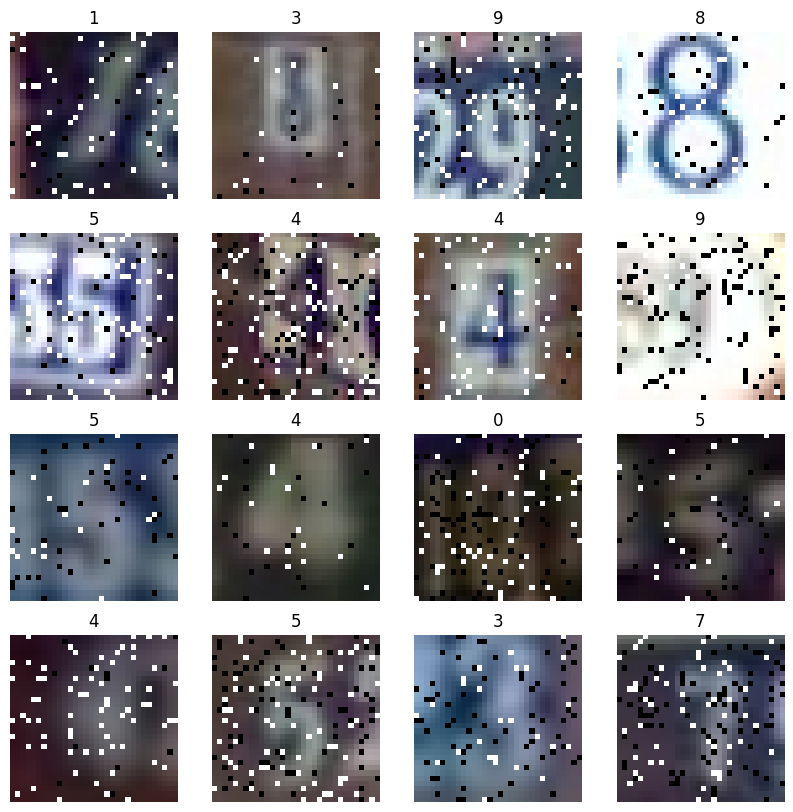

In [7]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(protect_ds_x[i] / 255, cmap=plt.cm.binary)
    plt.title(protect_ds_y[i])
    plt.axis('off')
plt.show()

Изобразим балансировку классов.

Text(0.5, 1.0, 'Class balance')

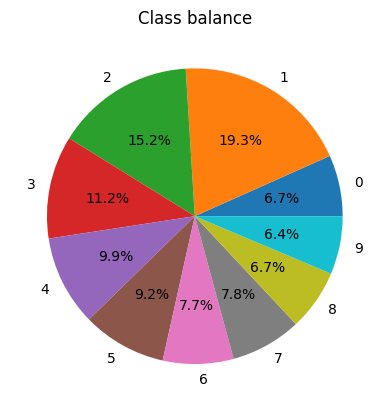

In [8]:
plt.pie([3341, 9650, 7595, 5625, 4941, 4604, 3859, 3876, 3332, 3177], labels=range(10), autopct='%.1f%%')
plt.title('Class balance')

- О датасете можно сказать следущие вещи:
    - В датасете на изображении бывают сразу несколько цифр, однако распозновать надо только ту, что находится посередине.
    - В данных присутсвуют битые пиксели.
    - Есть выбросы (картинку снизу слева распознать человеку просто невозможно).
    - Датасет имеет дисбаланс классов.

----
## 1.1 Битые пиксели.
В представленном датасете битые пиксели либо абсолютно чёрные, либо абсолютно белые. Очевидно их наличие значительно осложняет обучении модели и с ними необходимо бороться.

Также стоит отметить низкое качество изображений из датасета, что наводит на мысли о минимализации потерь при обработке - при работе с битыми пикселями нужно сохранить максимальное количество исходных данных.

Исходя из этих умозаключений отметаются сложные варианты удаления шума, более эффективные на больших изображениях, но потенциально способные сильно исказить данные на малом объёме. 

Нужен простой и эффективный метод, который будет с минимальными потерями восстанавливать изображение.

- Одним из вариантов стал GaussianBlur, однако картинка размывалась, фичи пропадали и битые пиксели все равно были видны. Можно посмотреть в файле [broken_pixels.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Comissar/BrokenPixels/broken_pixels.ipynb)

- Теоритическое обоснование разработанного метода:
    - Нужно стремиться к минимальному искажению изображения, поэтому работать мы будем только с битыми пикселями, идентифицируя их по абсолютным значениям (255, 255, 255), (0, 0, 0).
    - После детекции битого пикселя, мы присваиваем ему среднее значение среди восьми соседних пикселей. Однако если соседений пиксель тоже битый, то он не учитывается при подсчете среднего.

In [9]:
def is_broken_pixel(rgb_color):
    return np.array_equal(rgb_color, [1., 1., 1.]) or np.array_equal(rgb_color, [0., 0., 0.])


def get_average_pixel(image, i, j):
    pixels_bunch = image[i - 1:i + 2, j - 1:j + 2, :]
    good_pixels_summ = np.zeros(3)
    good_pixels_count = 0
    for i in range(len(pixels_bunch)):
        for j in range(len(pixels_bunch)):
            if not is_broken_pixel(pixels_bunch[i, j]):
                good_pixels_summ += pixels_bunch[i, j]
                good_pixels_count += 1
    if good_pixels_count == 0:
        return good_pixels_summ
    return good_pixels_summ / good_pixels_count


def repair_image(image):
    padding_image = np.full((len(image[0]) + 2, len(image[0]) + 2, 3), 0.)
    padding_image[:, :, 0] = np.pad(image[:, :, 0], pad_width=1, constant_values=0.)
    padding_image[:, :, 1] = np.pad(image[:, :, 1], pad_width=1, constant_values=0.)
    padding_image[:, :, 2] = np.pad(image[:, :, 2], pad_width=1, constant_values=0.)
    for i in range(1, len(padding_image) - 1):
        for j in range(1, len(padding_image) - 1):
            if is_broken_pixel(padding_image[i, j]):
                padding_image[i, j] = get_average_pixel(padding_image, i, j)
    return padding_image[1: -1, 1: -1, :]

Изобразим те же изображения, что мы показывали вначале, но уже после обработки битых пикселей.

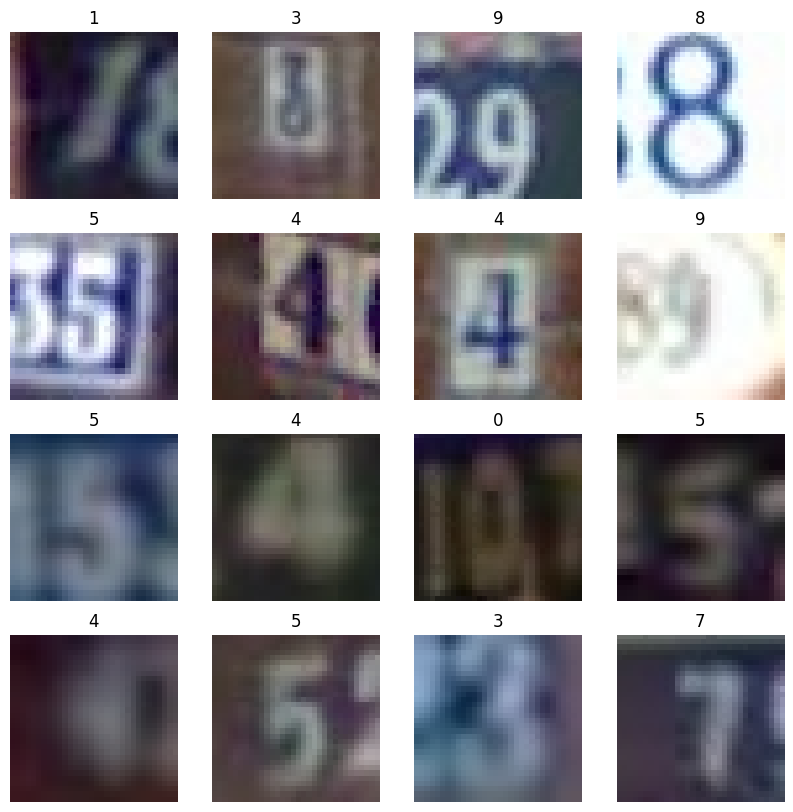

In [10]:
plt.figure(figsize=(10, 10))
for i in range(16):
    protect_ds_x[i] = repair_image(protect_ds_x[i] / 255) * 255
    plt.subplot(4, 4, i + 1)
    plt.imshow(protect_ds_x[i] / 255, cmap=plt.cm.binary)
    plt.title(protect_ds_y[i])
    plt.axis('off')
plt.show()

----
## 1.2 Аугментация.
- Это методика создания дополнительных обучающих данных из уже имеющихся.
### 1.2.1 Теория.
#### С какими проблемами помогает справиться аугментация?
- Помогает бороться с переобучением, потому что модель не будет получить одну картинку несколько раз.
- Видоизменяя изображение, аугментация готовит модель к `суровым` реальным данным.
### 1.2.2 Практика.
- При выборе агументации мы столкнулись с проблемой скудного выбора, предоставленного tensorflow для данного подхода обработки датасета.
- Мы остановились на torchvision, который предоставляет большое разнообразие вариантов аугментации.
- Мы рассмотрели все варианты аугментации, которые предоставляет torchvision, выделили все потенциально хоршие, сделали всевозможные комбинации из них и прогнали модель на каждой комбинации. Очень советую ознакомиться с файлами [augmentation.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/skewbek/Augmentation/augmentation.ipynb) и [aug_models.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/skewbek/Augmentation/aug_models.ipynb).
- По итогу у нас вышло несколько лидирующих комбинаций, лучшая из которых представлена ниже:

In [11]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4)
])

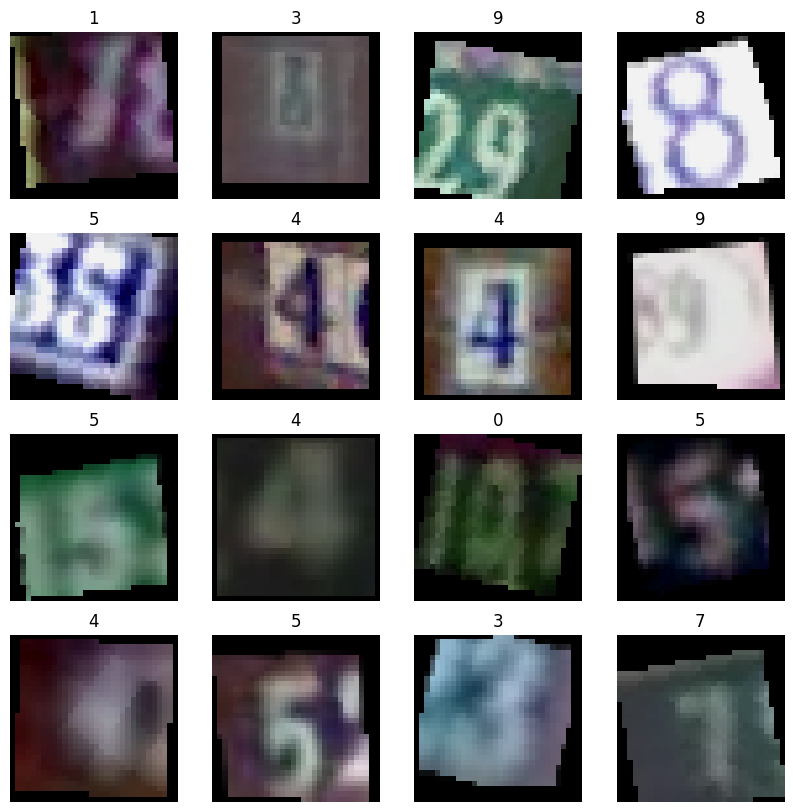

In [12]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = np.array(transformer(Image.fromarray(np.uint8(protect_ds_x[i]), 'RGB')))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title(protect_ds_y[i])
    plt.axis('off')
plt.show()

----
## 1.3 Работа с датасетом.

- Когда встал вопрос применения torchvision аугментации в моделях, написанных на tensorflow, мы пришли к решению написания класса-наследника от [tf.keras.utils.Sequence](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)

Советую ознакомиться с файлом [ds.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Liza/ds.ipynb)

In [13]:
def open_f(filename, back=2):
    filepath = os.path.join('../' * back, 'data', filename)
    with open(filepath, 'rb') as f:
        return pickle.load(f)


class DataSequence(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, transform=None, batch_size=512):
        self.x = x_set
        self.y = y_set
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.y.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        shuffle = np.random.permutation(batch_x.shape[0])
        batch_x, batch_y = batch_x[shuffle], batch_y[shuffle]
        if 'torchvision.transforms' in str(type(self.transform)):
            return (
                np.array([np.asarray(self.transform(Image.fromarray(np.uint8(x)))) / 255. for x in batch_x]),
                batch_y
            )
        return batch_x / 255, batch_y



def get_ds(file_train, file_test, transform=None, batch_size=512, one_hot=False, val_size=0.07, back=2):
    data_all = open_f(file_train, back)
    data_test = open_f(file_test, back)

    shuffle = np.random.permutation(data_all['images'].shape[0])
    train_images_full = data_all['images'][shuffle]
    train_labels_full = data_all['labels'][shuffle]
    if one_hot:
        train_labels_full = tf.one_hot(train_labels_full, 10).numpy()

    train_ds_x, val_ds_x, train_ds_y, val_ds_y = train_test_split(train_images_full, train_labels_full,
                                                                  test_size=val_size, random_state=1234)

    val_ds = tf.data.Dataset.from_tensor_slices((val_ds_x / 255., val_ds_y))
    val_ds = val_ds.batch(batch_size)

    train_ds = DataSequence(train_ds_x, train_ds_y, transform, batch_size=batch_size)

    test_ds = data_test['images'] / 255.

    return train_ds, val_ds, test_ds

Формируем экземпляр класса.

In [14]:
train_ds = DataSequence(protect_ds_x, protect_ds_y, transformer, batch_size=3)

Демонстрируем работу.

In [15]:
batch_example = train_ds[0]
batch_example

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.39607843, 0.2745098 , 0.39215686],
          ...,
          [0.15686275, 0.19607843, 0.21568627],
          [0.14509804, 0.18431373, 0.20784314],
          [0.12941176, 0.16862745, 0.19607843]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.40784314, 0.28627451, 0.41568627],
          ...,
          [0.17254902, 0.22745098, 0.23529412],
          [0.16862745, 0.21960784, 0.23529412],
          [0.14901961, 0.19215686, 0.22352941]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.41568627, 0.30980392, 0.43137255],
          ...,
          [0.17254902, 0.23529412, 0.25490196],
          [0.17254902, 0.23137255, 0.25098039],
          [0.14901961, 0.20392157, 0.22745098]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

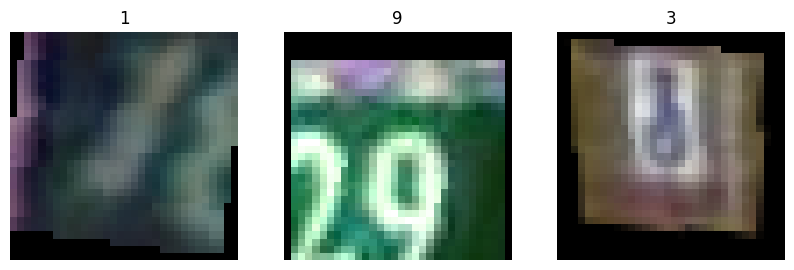

In [16]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(batch_example[0][i], cmap=plt.cm.binary)
    plt.title(batch_example[1][i])
    plt.axis('off')
plt.show()

----
## 1.4 Дисбаланс классов.
- Такая проблема возникает, когда количество выборок между разными классами несбалансировано, и результирующая модель ML будет смещена в сторону одного или нескольких классов с частыми выборками по сравнению с другими классами с нечастыми выборками.
### 1.4.1 UnderSampling
- Уменьшение кол-ва изображений. 
### 1.4.2 OverSampling
- увеличение кол-ва изображений(в нашем случае, на основе уже имеющихся).

 Мы пытались найти идельное кол-во экземпляров для каждого класса. 
- 4 варианта датасета:
    1. с дисбалансом классов.
    2. В каждом классе 5000 изображений.
    3. В каждом классе 7000 изображений.
    4. В каждом классе 9650 изображений.

Лучше всего себя показал датасет номер 3 (7000). Подробнее про OverSampling и о практике применения датасетов можно прочитать в файле [class_balance.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Griga/class_balance.ipynb)

----
----
# 2. Модели.
Нацонец-то мы переходим к основной части проекта. Далее мы рассмотрим архитектуры и подходы, которые не только показали хорошие метрики, но и привели нас к правильным выводам о необходимости использования того или иного метода.

----
## 2.1 Чекпоинты.
- Чтобы не обучать модель по два раза: обучение модели на большом кол-ве эпох (для того чтобы определить на какой эпохе начинается переобучение), обучение модели до переобучения; Tensorflow предоставляет возможность сохранять модель во время обучения на определенных эпохах.

### 2.1.1 Для этого мы должны скомпилировать модель с метриками, которые мы будем отслеживать.
```python
model.compile(
    optimizer=optimizer,
    metrics=['categorical_accuracy', tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')],
    loss=loss,
)
```
##### Мы указали такие метрики как `accuracy` и `f1_score`
##### $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$
##### $F\_score = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}}$
### 2.1.2 Далее мы должны добавить в `callbacks` необходимые чекпоинты.
#### 2.1.2.1 Классические чекпоинты.
Сохранение модели на эпохе с самым большим `accuracy`
```python
tf.keras.callbacks.ModelCheckpoint(
    filepath=f'model_categorical_accuracy.h5',
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
)
``` 
Сохранение модели на эпохе с самым маленьким `loss`
```python
tf.keras.callbacks.ModelCheckpoint(
    filepath=f'model_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)
```
Сохранение модели на эпохе с самым большим `f1_score`
```python
tf.keras.callbacks.ModelCheckpoint(
    filepath=f'model_f1_score.h5',
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
)
```

#### 2.1.2.1 Усредненные чекпоинты.
- TensorFlow Addons предоставляет функционал сохранения чекпоинта по усредненным весам. То есть чекпоинт выделяет несколько лучших эпох и усредняет веса между ними. Таким образом, мы делаем собирательный образ лучших эпох модели, что сильно помогает обобщить распознование классов.

Сохранение модели по максимальному среднему `accuracy`
```python
tfa.callbacks.AverageModelCheckpoint(
    update_weights=False,
    filepath=f'model_avg_categorical_accuracy.h5',
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
)
```
Сохранение модели по минимальному среднему `loss`
```python
tfa.callbacks.AverageModelCheckpoint(
    update_weights=False,
    filepath=f'model_avg_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)
```
Сохранение модели по максимальному среднему `f1_score`
```python
tfa.callbacks.AverageModelCheckpoint(
    update_weights=False,
    filepath=f'model_avg_f1_score.h5',
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
)
```

- #### Таким образом, мы получаем практически лучшие веса для модели. Еще плюсом является то, что, написав одну модель, мы имеем 6 чекпоинтов, которые можно отправить на kaggle и выявить лучший.
- Все чекпоинты мы сохраняли в папку [checkpoints](https://github.com/GrishaTS/YaMlProject/tree/main/models/checkpoints), для дальнейшего улучшения модели или ансамблирования.
### Как показала практика, лучшими чекпоинтами являются средний по `accuracy` и средний по `f1_score`

----
## 2.2 Оптимизаторы.
Так как мы используем AverageModelCheckpoint, то при компиляции модели в параметре оптимизаторы нужно указывать такую конфигурацию:
```python
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tensorflow.keras.optimizers.legacy.{optimizer}),
    metrics=metrics,
    loss=loss,
)
```
- Поэтому мы рассматривали тольке то оптимизаторы, которые были в tensorflow.keras.optimizers.legacy:
    - SGD
    - RMSProp
    - Adam
    - Adadelta 
    - Adagrad
    - Adamax
    - Nadam
    - Ftrl

- Однако в данном файле мы упомянем лишь один оптимизатор, который на наш счет оказались крайне хорошими: Adam.

### 2.2.1 [tensorflow.keras.optimizers.legacy.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy/Adam)
- СУТЬ: Adam = Momentum(метод моментов для ускорения процесса обучения) + RMSprop.
- ПРЕИМУЩЕСТВА:
    - Может обрабатывать разреженные градиенты на зашумленных наборах данных.
    - Значения гиперпараметров по умолчанию подходят для большинства задач.
    - Вычислительная эффективность.
    - Хорошо работает с большими наборами данных.
- НЕДОСТАТКИ:
    - Может требоваться большой объём памяти, так как Adam нужно много различных параметров.
    - Чтобы восстановить модель из чекпоинта, необходимо сохранять не только веса модели, но и накопленные параметры Adam, чтобы он не считал их заново.

Как и в теории, так и на практике мы пришли к выводу о том, что этот оптимизатор является максимально подходящим для данного датасета.

### 2.2.2 [tf.keras.callbacks.LearningRateScheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)
- Tensorflow предоставляет очень интересный callback, который позволяет менять lr по мере обучения модели.

Мы изучили данный инструмент и пришли к выводу о том, что постепенное уменьшение lr после 10 эпохи положительно влияет на обучение модели. Сходимость к оптимум функции loss-а сильно возрастает.
```python
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.03)


callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)]
```

### 2.2.3 decay и weight_decay
- В оптимизаторах присутствуют вышеуказанные параметры. В глубинном обучении часто используется техника Weight Decay, очень близкая к регуляризации Тихонова. Она представляет собой аналогичный штраф за высокие значения весов нейронной сети с коэффициентом регуляризации

Данный подход помог улучшить наши метрики. Значение этого параметра в проекте был примерно от 1e-6 до 1e-4

### Полный разбор всех оптимизаторов и подбор оптимальных параметров можно почитать в файле [optimizators.ipynb](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Liza/optimizators.ipynb)

----
## 2.3 Архитектуры.
### 2.3.1 Исследование.
- Перед написанием архитектур, мы изучили важные слои cv-нейросетей для полного понимания как все это работает.
- Повторюсь, что в этом файле мы делаем краткий пересказ, поэтому в загаловки следующих пунктов мы вставили ссылки на гит файлы, в которых есть и полная теория, и применения на практике.
#### 2.3.1.1 [Convolution](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Griga/ConvAndPool/conv_pool.ipynb)
- Сперва мы определили, какая из перечисленных (1D vs 2D vs 3D) сверток подходит больше всего.

Одной из задач свертки является показать зависимость соседних клеток, которые и формируют картинку. 1D Convolution не подойдет, потому что такой вариант свертки покажет зависимость соседних пикселей только в одной оси. 3D Convolution не уместен для данного датасета, потому что у нас изображения размером (32, 32, 3). 2D Convolution лучше всего подходит для классификации rgb изображений.
### Потом мы приступили к типам сверток (Здесь разберем только интересные):
### - Depthwise Convolution

[tf.keras.layers.DepthwiseConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D)

Плюсы:
- Уменьшаем кол-во вычеслений (сильно)
- Хорошо показываем зависимость соседних пикселей

Минусы:
- Мы не учитываем зависимость между слоями

![-](https://animatedai.github.io/media/depthwise-convolution-animation-3x3-kernel.gif)

Такой вариант свертки использовался в нашей лучшей модели.
### Separable Convolution

[tf.keras.layers.SeparableConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D)
Плюсы:
- Уменьшаем кол-во вычеслений (примерно в 9 раз!!!)
- Хорошо показываем зависимость соседних пикселей
- Мы учитываем зависимость между слоями

Минусы:
- Не заметил

![-](https://animatedai.github.io/media/depthwise-separable-convolution-animation-3x3-kernel.gif)

Очень интересный вариант свертки, который хорошо показывал себя в большинстве случае, однако в лучших моделях не оказался.

#### 2.3.1.2 [Pooling](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/Griga/ConvAndPool/conv_pool.ipynb)
- В данном пункте мы узучили 4 вида пулингов:
    - AveragePooling2D
    - MaxPool2D
    - GlobalAveragePooling2D
    - GlobalMaxPool2D

Однако сказать какой может быть лучше нельзя. Для данного датасета, взависимости от архитектуры, каждый из вариантов пулинга может раскрыться по-разному. Поэтому в моделях мы использовали все типы пулингов.
#### 2.3.1.3 [Skip-Connection](https://github.com/GrishaTS/YaMlProject/blob/main/notebooks/skewbek/SkipConnection/skip_conection.ipynb)
##### Проблемы с которыми борется skip-connection:
- Когда архитектуры моделей стали очень большими, то появилась проблема, названная затухающим градиентом. Skip-Connections смягчают проблему исчезновения градиента, позволяя этому альтернативному короткому пути проходить градиент.
- Когда мы производим различные действия над изображением (такие как свертка или pooling), то появляется возможность потерять фичи изображения, поэтому skip-connection также называют остаточным изображением.
- В данном пункте мы узучили все варианты skip-connections, предоставляеммые tensorflow.
- Как и в теории, так и на практике мы пришли к одному мнению: Для данного датасета самыми подходящими вариантами Skip-Connection являются
    - `tf.keras.layers.Concatenate`. На вход принимает список слоёв с одинаковым shape, кроме одного(будет указан в axis). Возвращает объединённый tensor, состоящий из входных слоёв. Помогает вообще не терять фичи, а просто переносит их с одного места на другое. 
    - `tf.keras.layers.Add`. Принимает слои с идентичной формой и возвращает поэлементную **сумму** значений нейронов на соответствующих местах

##### Skip-Connection присутсвует в каждой нашей лучшей модели.
### 2.3.2 Архитектуры наших нейросетей.
Переходим к самом интересному. Мы рассмотрели около 25 архитектур, среди которых есть как наши, так и те, что были написаны для ImageNet. Здесь мы рассмотрим 5 архитектур.

p.s.: все наши модели на последнем FC слое не имеют функцию активации, потому что при дальнейшей работе с ансамблями (про них написано ниже) лучше всего использовать необработанные логиты.
#### 2.3.2.1 GoogLeNet
[Модель G11](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_11.ipynb)

[Модель G17](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_17.ipynb)

[Модель G22](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_22.ipynb)

<img src="data/GoogLeNet.png" width="729"/>

На рисунке изображена схема локализованной под наш датасет гуглнет подобной модели. Такая архитектура показала очень хорошие метрики. Главной характерной оссобеностью данной модели является Inception блок. Идея таких блоков такова: мы не знаем какого размера свертку лучше всего применить на слое i, поэтому применяем сразу несколько сверток разного размера, объединяя их потом skip-connection-ом, таким образом каждая свертка выделяет разные фичи.

#### 2.3.2.2 SqueezeNet
[Модель G5](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_5.ipynb)

[Модель G6](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_6.ipynb)

[Модель G14](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_14.ipynb)

[Модель G15](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_15.ipynb)

<img src="data/SqueezeNet.png" width="200" />

Эта модель получилась не очень удачной. Сперва нам показалось, что данная модель слишком глубокая, что может вызывать проблему взрывного градиента (модель 5 и 6). Однако уменьшив кол-во squeeze блоков, ничего не поменялось. Я думаю, что данная модель предполагает другой датасет (в котором кол-во фичей будет больше) и глубокую архитектуру.


#### 2.3.2.3 DenceNet
[Модель G7](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_7.ipynb)

[Модель G16](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_16.ipynb)

<img src="data/DenceNet.png" width="200" />

Данная модель подавала большие надежды - она показывала неплохие метрики на тестовом датасета, однако по итогу не вошла в финальный ансамбль. Мне кажется, что такие плотные Dence блоки не должны быть в таком малом кол-ве (2 или 3), однако наш датасет крайне мал, как и кол-вом фичей в классах, так и кол-вом самих классов.

#### 2.3.2.4 Модель 1|20
[Модель G1](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_1.ipynb)

[Модель G20](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_20.ipynb)

<img src="data/m20.png" width="200" />

Это тоже неплохая модель, она написана классическим паттерном (как vgg). То есть мы только сжимаем изображение polling-ом или stride-ом, но увеличиваем кол-во фильтров в свертке. Мы писали несколько таких моделей, но у нас никак не получилось реализовать их хорошо (хотя явно можно было бы прийти к хорошим метрикам с такой архитектурой)

#### 2.3.2.5 MobileNetV2
[Модель S6](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_s_6.ipynb)

[Модель G21](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_21.ipynb)

[Модель G24](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_24.ipynb)

[Модель G25](https://github.com/GrishaTS/YaMlProject/blob/main/models/models/model_g_25.ipynb)

<img src="data/MobileNetV2.png" width="400" />

Это архитектура MobileNet подобной сети. Структура оказалась крайне удачна для данной задачи, у нас получилось хорошо ее локализировать.

Модель состоит из bottleneck layers:
1. pointwise convolution увеличивает количество каналов в t раз(создает отображение входного тензора в пространстве большой размерности)
2. depthwise convolution с RELU-6. В зависимости от шага(stride) слой либо уменьшает размер изображения, либо оставляет его
3. 1х1 свёртка с линейной активацией, понижающая число каналов.
- Высокая размерность, полученная после предыдущих шагов, укладывается в подпространство меньшей размерности без потери полезной информации.
- Правильная совокупность хороших блоков образует модель с отличными метриками. Модели с подобной архитектурой показали самые лучшие метрики.

----
## 2.4 Ансамбли
- Техника машинного обучения, использующая несколько обученных моделей с целью получения лучшей предсказательной эффективности, чем можно было бы получить от каждой модели по отдельности.

## Виды ансамблей:
### 2.4.1 Беггинг
- Теория: Принцип работы относительно несложный: мы берём логиты предиктов с каждой модели ансамбля и усредняем их, в конце выбираем максимальный. 
- Плюсы: Относительно несложно реализовать.
- Минусы: Структурно ограничен в возможностях. Только некоторое количество моделей и далее манипуляции с логитами их предиктов. 

#### Код:
- Все тестовые предикты мы сохраняли в папку [checkpoint_answers](https://github.com/GrishaTS/YaMlProject/tree/main/models/checkpoint_answers).
- Когда нужно было ансамблировать предикты, мы скачивали эта файли, а потом проводили различные эвристики.
```python
pred_1 = pickle.load(open('checkpoint_answers/model_1_avg_f1_score.h5', 'rb'))
pred_2 = pickle.load(open('checkpoint_answers/model_2_avg_f1_score.h5', 'rb'))
pred_3 = pickle.load(open('checkpoint_answers/model_3_avg_f1_score.h5', 'rb'))
ans = np.argmax(pred_2 + pred_3 + pred_1, axis=-1)
```

#### Bagging показал себя эффективным алгоритмом, который использовался в нашем лучшем предикте.

## 2.4.1 Стекинг

- Теория: Обучение мета-модели, которая принимает на вход ответы/логиты обученных моделей и выдаёт итоговые предикты.
- Плюсы: Модель сама определяет, какая из предоставленных моделей различает ту или иную цифру лучше.
- Минусы: умеренно сложен в реализации.

Данный вид ансамблей у нас не получился. Вероятнее всего из-за маленького кол-ва данных, однако при правильно подходе такая мета-модель могла крайне сильно улучшить метрики. Более корректную реализацию мы осуществим позже, но если хочется ознакомиться с нашей попыткой, то вот [файл](https://github.com/GrishaTS/YaMlProject/blob/main/models/ensemble/ensemble_G_9.ipynb).

## 2.4.2 Дерево решений

- Решающее дерево предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил. Этот процесс в некотором смысле согласуется с естественным для человека процессом принятия решений.

- Когда мы приступили к реализации данного ансамбля, у нас было два варианта написания моделей для решающего дерева:
    - Модели, обученные на различие конфликтных классах. К примеру (1 и 7, 6 и 9 итд)
    - OneVsAll модели. Модели, ответы которых означают следующие: Принадлежит ли фото i-ому классу.

Мы остановились на 2ом варианте, но он не привел нас к хорошим результатам из-за плохих моделей OneVsAll. Про них можно почитать [здесь](https://github.com/GrishaTS/YaMlProject/tree/main/models/models/one_vs_all)

----
----
# 3. Лучшее решение.
В этом пункте мы распишем наше лучшее решение. Код не рабочий, он представлен для визуализации происходящего.

Однако весь код в [репозитории](https://github.com/GrishaTS/YaMlProject/) рабочий.

В некоторых моделях не присутсвует график обучения, потому что в конце проектной части мы заметили, что модели с PlotLossKeras учатся сильно дольше чем модели без, но взамен мы предоставим метрики на каждой эпохе.

## 3.1 Модели

### 3.1.1 S6

In [17]:
num_model = '_s_6'

In [18]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-12, 12), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

In [ ]:
train_ds, val_ds, test_ds = get_ds('smote_data_train_9650', 'repaired_data_test', transform=transformer,
                                   one_hot=True, back=0, batch_size=100)

In [ ]:
def get_metrics_and_callbacks(num_model):
    metrics = ['categorical_accuracy',
            tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
    callbacks = [
        PlotLossesKeras(),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
            monitor='val_categorical_accuracy',
            mode='max',
            save_best_only=True,
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'../checkpoints/model{num_model}_loss.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'../checkpoints/model{num_model}_f1_score.h5',
            monitor='val_f1_score',
            mode='max',
            save_best_only=True,
        ),

        tfa.callbacks.AverageModelCheckpoint(
            update_weights=False,
            filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
            monitor='val_categorical_accuracy',
            mode='max',
            save_best_only=True,
        ),
        tfa.callbacks.AverageModelCheckpoint(
            update_weights=False,
            filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
        ),
        tfa.callbacks.AverageModelCheckpoint(
            update_weights=False,
            filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
            monitor='val_f1_score',
            mode='max',
            save_best_only=True,
        )
    ]
    return metrics, callbacks

In [2]:
def get_block(input_, filters, t, stride):
    in_ = input_.shape[-1]

    x = tf.keras.layers.Conv2D(in_ * t, 1, strides=1, padding='same', use_bias=False)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x)

    x = tf.keras.layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x)

    x = tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x if in_ != filters else tf.keras.layers.Add()([input_, x])


model_input = tf.keras.Input(shape=(32, 32, 3), batch_size=100)

x = tf.keras.layers.Conv2D(32, 3, strides=1, padding='same', use_bias=False)(model_input)

x = get_block(x, 16, 1, 1)

x = get_block(x, 24, 6, 1)
x = get_block(x, 24, 6, 1)

x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)

x = get_block(x, 64, 6, 2)
x = get_block(x, 64, 6, 1)
x = get_block(x, 64, 6, 1)
x = get_block(x, 64, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = get_block(x, 96, 6, 1)
x = get_block(x, 96, 6, 1)
x = get_block(x, 96, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = get_block(x, 160, 6, 2)
x = get_block(x, 160, 6, 1)
x = get_block(x, 160, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = get_block(x, 320, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(1280, 1, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)

model = tf.keras.models.Model(inputs=model_input, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(100, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (100, 32, 32, 32)    864         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (100, 32, 32, 32)    1024        ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (100, 32, 32, 32)   128         ['conv2d_1[0][0]']               
 alization)                                                                                   

In [ ]:
metrics, callbacks = get_metrics_and_callbacks(num_model)

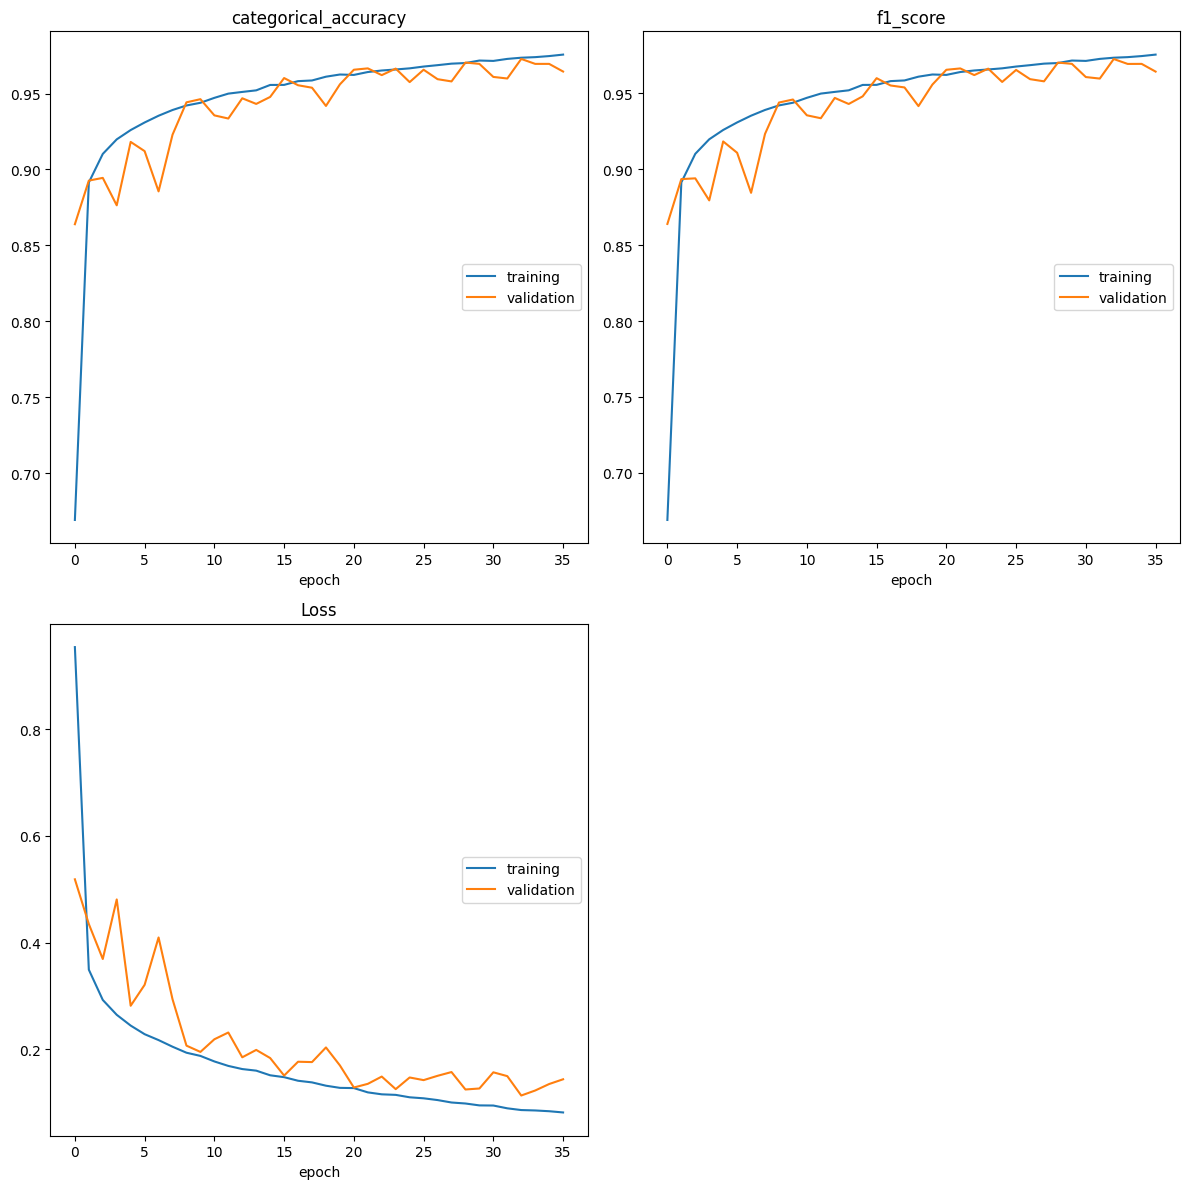

categorical_accuracy
	training         	 (min:    0.669, max:    0.976, cur:    0.976)
	validation       	 (min:    0.864, max:    0.973, cur:    0.964)
f1_score
	training         	 (min:    0.669, max:    0.976, cur:    0.976)
	validation       	 (min:    0.864, max:    0.973, cur:    0.964)
Loss
	training         	 (min:    0.082, max:    0.954, cur:    0.082)
	validation       	 (min:    0.114, max:    0.519, cur:    0.144)
898/898 [==============================] - 280s 311ms/step - loss: 0.0818 - categorical_accuracy: 0.9756 - f1_score: 0.9756 - val_loss: 0.1440 - val_categorical_accuracy: 0.9645 - val_f1_score: 0.9644
Epoch 37/100
786/898 [=========================>....] - ETA: 34s - loss: 0.0801 - categorical_accuracy: 0.9757 - f1_score: 0.9757

In [ ]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Колаб остановил обучение, поэтому мы продолжили в следующей ячейке.

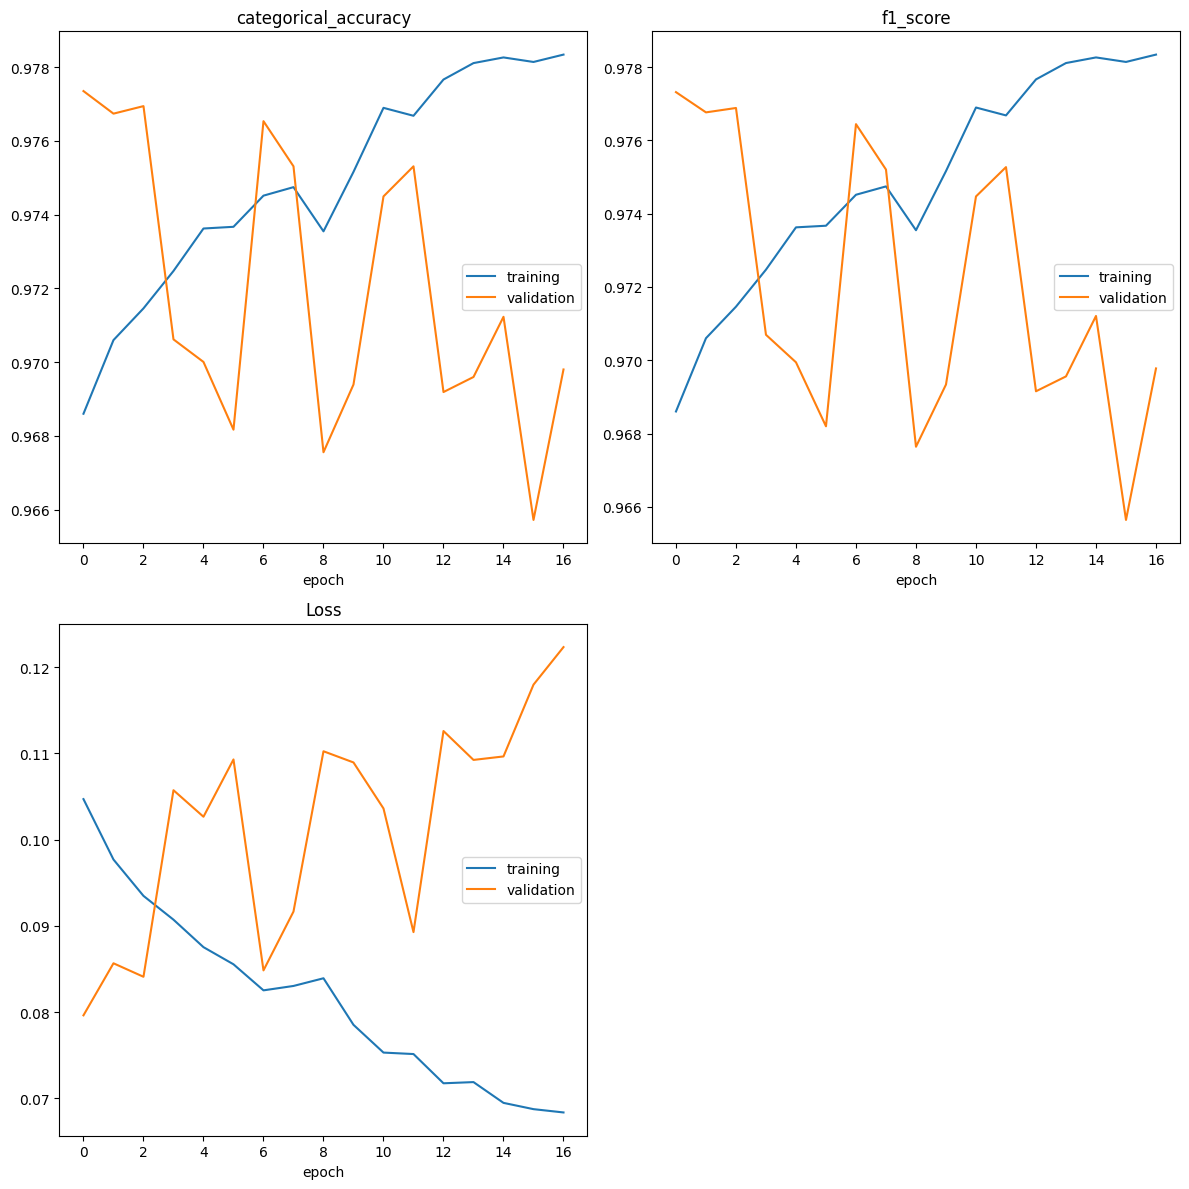

categorical_accuracy
	training         	 (min:    0.969, max:    0.978, cur:    0.978)
	validation       	 (min:    0.966, max:    0.977, cur:    0.970)
f1_score
	training         	 (min:    0.969, max:    0.978, cur:    0.978)
	validation       	 (min:    0.966, max:    0.977, cur:    0.970)
Loss
	training         	 (min:    0.068, max:    0.105, cur:    0.068)
	validation       	 (min:    0.080, max:    0.122, cur:    0.122)
651/651 [==============================] - 202s 310ms/step - loss: 0.0684 - categorical_accuracy: 0.9783 - f1_score: 0.9783 - val_loss: 0.1223 - val_categorical_accuracy: 0.9698 - val_f1_score: 0.9698
Epoch 18/100
334/651 [==============>...............] - ETA: 1:36 - loss: 0.0596 - categorical_accuracy: 0.9807 - f1_score: 0.9808

In [16]:
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Метрики на kaggle: 0.95045; 0.9512 (публичный и приватный accuracy)

### 3.1.2 G21

In [ ]:
num_model = '_g_21'

In [19]:
model_input = tf.keras.Input(shape=(32, 32, 3), batch_size=100)

x = tf.keras.layers.Conv2D(32, 3, strides=1, padding='same', use_bias=False)(model_input)

x = get_block(x, 16, 1, 1)

x = get_block(x, 24, 6, 1)
x = get_block(x, 24, 6, 1)

x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)

x = get_block(x, 64, 6, 2)
x = get_block(x, 64, 6, 1)
x = get_block(x, 64, 6, 1)
x = get_block(x, 64, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = get_block(x, 96, 6, 1)
x = get_block(x, 96, 6, 1)
x = get_block(x, 96, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = get_block(x, 160, 6, 2)
x = get_block(x, 160, 6, 1)
x = get_block(x, 160, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = get_block(x, 320, 6, 1)

x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(1280, 1, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)

model = tf.keras.models.Model(inputs=model_input, outputs=x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(100, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (100, 32, 32, 32)    864         ['input_2[0][0]']                
                                                                                                  
 conv2d_37 (Conv2D)             (100, 32, 32, 32)    1024        ['conv2d_36[0][0]']              
                                                                                                  
 batch_normalization_52 (BatchN  (100, 32, 32, 32)   128         ['conv2d_37[0][0]']              
 ormalization)                                                                              

In [ ]:
metrics, callbacks = get_metrics_and_callbacks(num_model)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.008)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

In [ ]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100

651/651 [==============================] - 240s 340ms/step - loss: 1.0553 - categorical_accuracy: 0.6334 - f1_score: 0.6330 - val_loss: 0.5894 - 
val_categorical_accuracy: 0.8406 - val_f1_score: 0.8420 - lr: 0.0016

Epoch 2/100

651/651 [==============================] - 210s 322ms/step - loss: 0.3800 - categorical_accuracy: 0.8825 - f1_score: 0.8824 - val_loss: 0.5054 - 
val_categorical_accuracy: 0.8723 - val_f1_score: 0.8717 - lr: 0.0016

Epoch 3/100

651/651 [==============================] - 209s 322ms/step - loss: 0.3171 - categorical_accuracy: 0.9025 - f1_score: 0.9025 - val_loss: 0.3926 - 
val_categorical_accuracy: 0.9000 - val_f1_score: 0.9006 - lr: 0.0016

Epoch 4/100

651/651 [==============================] - 209s 321ms/step - loss: 0.2887 - categorical_accuracy: 0.9132 - f1_score: 0.9131 - val_loss: 0.3383 - 
val_categorical_accuracy: 0.9110 - val_f1_score: 0.9110 - lr: 0.0016

Epoch 5/100

651/651 [==============================] - 205s 315ms/step - loss: 0.2707 - categorical_accuracy: 0.9174 - f1_score: 0.9174 - val_loss: 0.3768 - 
val_categorical_accuracy: 0.9037 - val_f1_score: 0.9044 - lr: 0.0016

Epoch 6/100

651/651 [==============================] - 203s 311ms/step - loss: 0.2531 - categorical_accuracy: 0.9243 - f1_score: 0.9243 - val_loss: 0.4534 - 
val_categorical_accuracy: 0.8770 - val_f1_score: 0.8809 - lr: 0.0016

Epoch 7/100

651/651 [==============================] - 209s 321ms/step - loss: 0.2444 - categorical_accuracy: 0.9270 - f1_score: 0.9270 - val_loss: 0.2744 - 
val_categorical_accuracy: 0.9280 - val_f1_score: 0.9281 - lr: 0.0016

Epoch 8/100

651/651 [==============================] - 209s 321ms/step - loss: 0.2293 - categorical_accuracy: 0.9323 - f1_score: 0.9323 - val_loss: 0.2194 - 
val_categorical_accuracy: 0.9376 - val_f1_score: 0.9373 - lr: 0.0016

Epoch 9/100

651/651 [==============================] - 200s 307ms/step - loss: 0.2211 - categorical_accuracy: 0.9355 - f1_score: 0.9355 - val_loss: 0.2556 - 
val_categorical_accuracy: 0.9282 - val_f1_score: 0.9282 - lr: 0.0016

Epoch 10/100

651/651 [==============================] - 200s 307ms/step - loss: 0.2104 - categorical_accuracy: 0.9373 - f1_score: 0.9373 - val_loss: 0.2782 - 
val_categorical_accuracy: 0.9243 - val_f1_score: 0.9242 - lr: 0.0016

Epoch 11/100

651/651 [==============================] - 206s 316ms/step - loss: 0.1980 - categorical_accuracy: 0.9419 - f1_score: 0.9419 - val_loss: 0.2319 - 
val_categorical_accuracy: 0.9388 - val_f1_score: 0.9388 - lr: 0.0016

Epoch 12/100

651/651 [==============================] - 209s 320ms/step - loss: 0.1919 - categorical_accuracy: 0.9431 - f1_score: 0.9430 - val_loss: 0.1803 - 
val_categorical_accuracy: 0.9506 - val_f1_score: 0.9506 - lr: 0.0015

Epoch 13/100

651/651 [==============================] - 209s 321ms/step - loss: 0.1810 - categorical_accuracy: 0.9460 - f1_score: 0.9460 - val_loss: 0.1747 - 
val_categorical_accuracy: 0.9543 - val_f1_score: 0.9546 - lr: 0.0015

Epoch 14/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1773 - categorical_accuracy: 0.9473 - f1_score: 0.9473 - val_loss: 0.2090 - 
val_categorical_accuracy: 0.9474 - val_f1_score: 0.9477 - lr: 0.0014

Epoch 15/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1672 - categorical_accuracy: 0.9518 - f1_score: 0.9518 - val_loss: 0.1954 - 
val_categorical_accuracy: 0.9435 - val_f1_score: 0.9437 - lr: 0.0014

Epoch 16/100

651/651 [==============================] - 203s 312ms/step - loss: 0.1623 - categorical_accuracy: 0.9522 - f1_score: 0.9521 - val_loss: 0.2015 - 
val_categorical_accuracy: 0.9453 - val_f1_score: 0.9454 - lr: 0.0013

Epoch 17/100

651/651 [==============================] - 209s 322ms/step - loss: 0.1556 - categorical_accuracy: 0.9534 - f1_score: 0.9534 - val_loss: 0.1415 - 
val_categorical_accuracy: 0.9627 - val_f1_score: 0.9627 - lr: 0.0013

Epoch 18/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1485 - categorical_accuracy: 0.9554 - f1_score: 0.9554 - val_loss: 0.1632 - 
val_categorical_accuracy: 0.9600 - val_f1_score: 0.9602 - lr: 0.0013

Epoch 19/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1420 - categorical_accuracy: 0.9575 - f1_score: 0.9575 - val_loss: 0.1639 - 
val_categorical_accuracy: 0.9588 - val_f1_score: 0.9588 - lr: 0.0012

Epoch 20/100

651/651 [==============================] - 206s 316ms/step - loss: 0.1330 - categorical_accuracy: 0.9606 - f1_score: 0.9606 - val_loss: 0.1479 - 
val_categorical_accuracy: 0.9633 - val_f1_score: 0.9633 - lr: 0.0012

Epoch 21/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1303 - categorical_accuracy: 0.9613 - f1_score: 0.9613 - val_loss: 0.1649 - 
val_categorical_accuracy: 0.9588 - val_f1_score: 0.9588 - lr: 0.0012

Epoch 22/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1266 - categorical_accuracy: 0.9630 - f1_score: 0.9630 - val_loss: 0.1797 - 
val_categorical_accuracy: 0.9516 - val_f1_score: 0.9515 - lr: 0.0011

Epoch 23/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1209 - categorical_accuracy: 0.9640 - f1_score: 0.9640 - val_loss: 0.1569 - 
val_categorical_accuracy: 0.9604 - val_f1_score: 0.9604 - lr: 0.0011

Epoch 24/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1153 - categorical_accuracy: 0.9659 - f1_score: 0.9659 - val_loss: 0.1655 - 
val_categorical_accuracy: 0.9551 - val_f1_score: 0.9551 - lr: 0.0011

Epoch 25/100

651/651 [==============================] - 200s 307ms/step - loss: 0.1130 - categorical_accuracy: 0.9657 - f1_score: 0.9657 - val_loss: 0.1496 - 
val_categorical_accuracy: 0.9618 - val_f1_score: 0.9618 - lr: 0.0010

Epoch 26/100

651/651 [==============================] - 206s 316ms/step - loss: 0.1071 - categorical_accuracy: 0.9679 - f1_score: 0.9679 - val_loss: 0.1420 - 
val_categorical_accuracy: 0.9641 - val_f1_score: 0.9642 - lr: 9.9005e-04

Epoch 27/100

651/651 [==============================] - 209s 322ms/step - loss: 0.1035 - categorical_accuracy: 0.9695 - f1_score: 0.9695 - val_loss: 0.1332 - 
val_categorical_accuracy: 0.9678 - val_f1_score: 0.9677 - lr: 9.6079e-04

Epoch 28/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0995 - categorical_accuracy: 0.9698 - f1_score: 0.9698 - val_loss: 0.1530 - 
val_categorical_accuracy: 0.9633 - val_f1_score: 0.9632 - lr: 9.3240e-04

Epoch 29/100

651/651 [==============================] - 208s 320ms/step - loss: 0.0943 - categorical_accuracy: 0.9720 - f1_score: 0.9720 - val_loss: 0.1323 - 
val_categorical_accuracy: 0.9680 - val_f1_score: 0.9680 - lr: 9.0484e-04

Epoch 30/100

651/651 [==============================] - 202s 310ms/step - loss: 0.0930 - categorical_accuracy: 0.9721 - f1_score: 0.9721 - val_loss: 0.1362 - 
val_categorical_accuracy: 0.9655 - val_f1_score: 0.9655 - lr: 8.7810e-04

Epoch 31/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0878 - categorical_accuracy: 0.9737 - f1_score: 0.9737 - val_loss: 0.1796 - 
val_categorical_accuracy: 0.9539 - val_f1_score: 0.9539 - lr: 8.5215e-04

Epoch 32/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0820 - categorical_accuracy: 0.9745 - f1_score: 0.9745 - val_loss: 0.1439 - 
val_categorical_accuracy: 0.9647 - val_f1_score: 0.9647 - lr: 8.2696e-04

Epoch 33/100

651/651 [==============================] - 200s 306ms/step - loss: 0.0818 - categorical_accuracy: 0.9749 - f1_score: 0.9749 - val_loss: 0.1549 - 
val_categorical_accuracy: 0.9623 - val_f1_score: 0.9622 - lr: 8.0252e-04

Epoch 34/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0783 - categorical_accuracy: 0.9759 - f1_score: 0.9759 - val_loss: 0.1522 - 
val_categorical_accuracy: 0.9657 - val_f1_score: 0.9656 - lr: 7.7880e-04

Epoch 35/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0744 - categorical_accuracy: 0.9766 - f1_score: 0.9766 - val_loss: 0.1441 - 
val_categorical_accuracy: 0.9667 - val_f1_score: 0.9667 - lr: 7.5579e-04

Epoch 36/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0738 - categorical_accuracy: 0.9771 - f1_score: 0.9771 - val_loss: 0.1433 - 
val_categorical_accuracy: 0.9645 - val_f1_score: 0.9645 - lr: 7.3345e-04

Epoch 37/100

651/651 [==============================] - 209s 321ms/step - loss: 0.0699 - categorical_accuracy: 0.9783 - f1_score: 0.9783 - val_loss: 0.1278 - 
val_categorical_accuracy: 0.9714 - val_f1_score: 0.9715 - lr: 7.1177e-04

Epoch 38/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0659 - categorical_accuracy: 0.9795 - f1_score: 0.9795 - val_loss: 0.1341 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9707 - lr: 6.9074e-04

Epoch 39/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0647 - categorical_accuracy: 0.9796 - f1_score: 0.9796 - val_loss: 0.1411 - 
val_categorical_accuracy: 0.9680 - val_f1_score: 0.9680 - lr: 6.7032e-04

Epoch 40/100

651/651 [==============================] - 202s 311ms/step - loss: 0.0634 - categorical_accuracy: 0.9803 - f1_score: 0.9803 - val_loss: 0.1437 - 
val_categorical_accuracy: 0.9653 - val_f1_score: 0.9653 - lr: 6.5051e-04

Epoch 41/100

651/651 [==============================] - 206s 316ms/step - loss: 0.0605 - categorical_accuracy: 0.9810 - f1_score: 0.9809 - val_loss: 0.1303 - 
val_categorical_accuracy: 0.9718 - val_f1_score: 0.9718 - lr: 6.3129e-04

Epoch 42/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0586 - categorical_accuracy: 0.9814 - f1_score: 0.9814 - val_loss: 0.1396 - 
val_categorical_accuracy: 0.9716 - val_f1_score: 0.9716 - lr: 6.1263e-04

Epoch 43/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0532 - categorical_accuracy: 0.9832 - f1_score: 0.9832 - val_loss: 0.1614 - 
val_categorical_accuracy: 0.9639 - val_f1_score: 0.9639 - lr: 5.9452e-04

Epoch 44/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0564 - categorical_accuracy: 0.9825 - f1_score: 0.9825 - val_loss: 0.1417 - 
val_categorical_accuracy: 0.9678 - val_f1_score: 0.9678 - lr: 5.7695e-04

Epoch 45/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0505 - categorical_accuracy: 0.9839 - f1_score: 0.9839 - val_loss: 0.1456 - 
val_categorical_accuracy: 0.9714 - val_f1_score: 0.9713 - lr: 5.5990e-04

Epoch 46/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0515 - categorical_accuracy: 0.9840 - f1_score: 0.9840 - val_loss: 0.1609 - 
val_categorical_accuracy: 0.9669 - val_f1_score: 0.9670 - lr: 5.4335e-04

Epoch 47/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0461 - categorical_accuracy: 0.9848 - f1_score: 0.9848 - val_loss: 0.1485 - 
val_categorical_accuracy: 0.9671 - val_f1_score: 0.9672 - lr: 5.2730e-04

Epoch 48/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0458 - categorical_accuracy: 0.9855 - f1_score: 0.9855 - val_loss: 0.1473 - 
val_categorical_accuracy: 0.9702 - val_f1_score: 0.9703 - lr: 5.1171e-04

Epoch 49/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0439 - categorical_accuracy: 0.9864 - f1_score: 0.9864 - val_loss: 0.1531 - 
val_categorical_accuracy: 0.9694 - val_f1_score: 0.9695 - lr: 4.9659e-04

Epoch 50/100

651/651 [==============================] - 206s 316ms/step - loss: 0.0425 - categorical_accuracy: 0.9860 - f1_score: 0.9860 - val_loss: 0.1378 - 
val_categorical_accuracy: 0.9733 - val_f1_score: 0.9732 - lr: 4.8191e-04

Epoch 51/100

651/651 [==============================] - 206s 316ms/step - loss: 0.0421 - categorical_accuracy: 0.9865 - f1_score: 0.9865 - val_loss: 0.1364 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9738 - lr: 4.6767e-04

Epoch 52/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0392 - categorical_accuracy: 0.9872 - f1_score: 0.9872 - val_loss: 0.1368 - 
val_categorical_accuracy: 0.9725 - val_f1_score: 0.9724 - lr: 4.5385e-04

Epoch 53/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0384 - categorical_accuracy: 0.9872 - f1_score: 0.9872 - val_loss: 0.1481 - 
val_categorical_accuracy: 0.9735 - val_f1_score: 0.9735 - lr: 4.4043e-04

Epoch 54/100

651/651 [==============================] - 206s 316ms/step - loss: 0.0364 - categorical_accuracy: 0.9879 - f1_score: 0.9879 - val_loss: 0.1417 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9747 - lr: 4.2742e-04

Epoch 55/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0351 - categorical_accuracy: 0.9885 - f1_score: 0.9885 - val_loss: 0.1465 - 
val_categorical_accuracy: 0.9727 - val_f1_score: 0.9726 - lr: 4.1479e-04

Epoch 56/100

651/651 [==============================] - 206s 316ms/step - loss: 0.0359 - categorical_accuracy: 0.9880 - f1_score: 0.9880 - val_loss: 0.1337 - 

val_categorical_accuracy: 0.9755 - val_f1_score: 0.9755 - lr: 4.0253e-04

Epoch 57/100

651/651 [==============================] - 205s 315ms/step - loss: 0.0332 - categorical_accuracy: 0.9894 - f1_score: 0.9894 - val_loss: 0.1373 - 
val_categorical_accuracy: 0.9769 - val_f1_score: 0.9769 - lr: 3.9063e-04

Epoch 58/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0312 - categorical_accuracy: 0.9896 - f1_score: 0.9896 - val_loss: 0.1416 - 
val_categorical_accuracy: 0.9755 - val_f1_score: 0.9755 - lr: 3.7909e-04

Epoch 59/100

651/651 [==============================] - 203s 311ms/step - loss: 0.0286 - categorical_accuracy: 0.9902 - f1_score: 0.9902 - val_loss: 0.1377 - 
val_categorical_accuracy: 0.9769 - val_f1_score: 0.9770 - lr: 3.6788e-04

Epoch 60/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0288 - categorical_accuracy: 0.9903 - f1_score: 0.9903 - val_loss: 0.1408 - 
val_categorical_accuracy: 0.9755 - val_f1_score: 0.9755 - lr: 3.5701e-04

Epoch 61/100

651/651 [==============================] - 206s 317ms/step - loss: 0.0308 - categorical_accuracy: 0.9896 - f1_score: 0.9896 - val_loss: 0.1470 - 
val_categorical_accuracy: 0.9774 - val_f1_score: 0.9773 - lr: 3.4646e-04

Epoch 62/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0290 - categorical_accuracy: 0.9907 - f1_score: 0.9907 - val_loss: 0.1452 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9747 - lr: 3.3622e-04

Epoch 63/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0267 - categorical_accuracy: 0.9915 - f1_score: 0.9915 - val_loss: 0.1581 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9747 - lr: 3.2628e-04

Epoch 64/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0252 - categorical_accuracy: 0.9919 - f1_score: 0.9919 - val_loss: 0.1565 - 
val_categorical_accuracy: 0.9743 - val_f1_score: 0.9743 - lr: 3.1664e-04

Epoch 65/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0275 - categorical_accuracy: 0.9915 - f1_score: 0.9915 - val_loss: 0.1552 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9747 - lr: 3.0728e-04

Epoch 66/100

 72/651 [==>...........................] - ETA: 2:54 - loss: 0.0257 - categorical_accuracy: 0.9924 - f1_score: 0.9924


ПРОДОЛЖЕНИЕ ОБУЧЕНИЯ

651/651 [==============================] - 233s 332ms/step - loss: 0.0983 - categorical_accuracy: 0.9702 - f1_score: 0.9702 - val_loss: 0.1666 - 
val_categorical_accuracy: 0.9553 - val_f1_score: 0.9555 - lr: 0.0016

Epoch 2/100

651/651 [==============================] - 211s 324ms/step - loss: 0.0971 - categorical_accuracy: 0.9696 - f1_score: 0.9696 - val_loss: 0.0936 - 
val_categorical_accuracy: 0.9729 - val_f1_score: 0.9731 - lr: 0.0016

Epoch 3/100

651/651 [==============================] - 199s 305ms/step - loss: 0.0999 - categorical_accuracy: 0.9686 - f1_score: 0.9686 - val_loss: 0.1755 - 
val_categorical_accuracy: 0.9539 - val_f1_score: 0.9541 - lr: 0.0016

Epoch 4/100

651/651 [==============================] - 209s 321ms/step - loss: 0.0972 - categorical_accuracy: 0.9702 - f1_score: 0.9702 - val_loss: 0.0885 - 
val_categorical_accuracy: 0.9769 - val_f1_score: 0.9770 - lr: 0.0016

Epoch 5/100

651/651 [==============================] - 199s 305ms/step - loss: 0.0976 - categorical_accuracy: 0.9692 - f1_score: 0.9692 - val_loss: 0.0933 - 
val_categorical_accuracy: 0.9735 - val_f1_score: 0.9736 - lr: 0.0016

Epoch 6/100

651/651 [==============================] - 198s 305ms/step - loss: 0.0994 - categorical_accuracy: 0.9692 - f1_score: 0.9692 - val_loss: 0.0915 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9738 - lr: 0.0016

Epoch 7/100

651/651 [==============================] - 198s 304ms/step - loss: 0.0945 - categorical_accuracy: 0.9702 - f1_score: 0.9702 - val_loss: 0.1370 - 
val_categorical_accuracy: 0.9608 - val_f1_score: 0.9609 - lr: 0.0016

Epoch 8/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0919 - categorical_accuracy: 0.9718 - f1_score: 0.9718 - val_loss: 0.1166 - 
val_categorical_accuracy: 0.9680 - val_f1_score: 0.9682 - lr: 0.0016

Epoch 9/100

651/651 [==============================] - 198s 304ms/step - loss: 0.0939 - categorical_accuracy: 0.9708 - f1_score: 0.9708 - val_loss: 0.1131 - 
val_categorical_accuracy: 0.9680 - val_f1_score: 0.9681 - lr: 0.0016

Epoch 10/100

651/651 [==============================] - 198s 303ms/step - loss: 0.0881 - categorical_accuracy: 0.9729 - f1_score: 0.9729 - val_loss: 0.0939 - 
val_categorical_accuracy: 0.9733 - val_f1_score: 0.9733 - lr: 0.0016

Epoch 11/100

651/651 [==============================] - 198s 303ms/step - loss: 0.0872 - categorical_accuracy: 0.9728 - f1_score: 0.9728 - val_loss: 0.1085 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9708 - lr: 0.0016

Epoch 12/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0817 - categorical_accuracy: 0.9745 - f1_score: 0.9744 - val_loss: 0.1055 - 
val_categorical_accuracy: 0.9731 - val_f1_score: 0.9732 - lr: 0.0015

Epoch 13/100

651/651 [==============================] - 199s 306ms/step - loss: 0.0798 - categorical_accuracy: 0.9750 - f1_score: 0.9750 - val_loss: 0.1003 - 
val_categorical_accuracy: 0.9716 - val_f1_score: 0.9719 - lr: 0.0015

Epoch 14/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0747 - categorical_accuracy: 0.9768 - f1_score: 0.9768 - val_loss: 0.1128 - 
val_categorical_accuracy: 0.9733 - val_f1_score: 0.9735 - lr: 0.0014

Epoch 15/100

651/651 [==============================] - 199s 306ms/step - loss: 0.0746 - categorical_accuracy: 0.9768 - f1_score: 0.9768 - val_loss: 0.1241 - 
val_categorical_accuracy: 0.9671 - val_f1_score: 0.9671 - lr: 0.0014

Epoch 16/100

651/651 [==============================] - 197s 302ms/step - loss: 0.0727 - categorical_accuracy: 0.9768 - f1_score: 0.9768 - val_loss: 0.1090 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9737 - lr: 0.0013

Epoch 17/100

651/651 [==============================] - 198s 303ms/step - loss: 0.0673 - categorical_accuracy: 0.9786 - f1_score: 0.9786 - val_loss: 0.1018 - 
val_categorical_accuracy: 0.9753 - val_f1_score: 0.9754 - lr: 0.0013

Epoch 18/100

651/651 [==============================] - 197s 302ms/step - loss: 0.0644 - categorical_accuracy: 0.9790 - f1_score: 0.9790 - val_loss: 0.1048 - 
val_categorical_accuracy: 0.9767 - val_f1_score: 0.9768 - lr: 0.0013

Epoch 19/100

651/651 [==============================] - 196s 302ms/step - loss: 0.0616 - categorical_accuracy: 0.9799 - f1_score: 0.9799 - val_loss: 0.1184 - 
val_categorical_accuracy: 0.9718 - val_f1_score: 0.9718 - lr: 0.0012

Epoch 20/100

651/651 [==============================] - 199s 306ms/step - loss: 0.0578 - categorical_accuracy: 0.9819 - f1_score: 0.9819 - val_loss: 0.1040 - 
val_categorical_accuracy: 0.9731 - val_f1_score: 0.9731 - lr: 0.0012

Epoch 21/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0576 - categorical_accuracy: 0.9820 - f1_score: 0.9820 - val_loss: 0.0957 - 
val_categorical_accuracy: 0.9761 - val_f1_score: 0.9763 - lr: 0.0012

Epoch 22/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0557 - categorical_accuracy: 0.9824 - f1_score: 0.9824 - val_loss: 0.1177 - 
val_categorical_accuracy: 0.9720 - val_f1_score: 0.9721 - lr: 0.0011

Epoch 23/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0511 - categorical_accuracy: 0.9836 - f1_score: 0.9836 - val_loss: 0.1075 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9765 - lr: 0.0011

Epoch 24/100

651/651 [==============================] - 199s 306ms/step - loss: 0.0488 - categorical_accuracy: 0.9841 - f1_score: 0.9841 - val_loss: 0.0953 - 
val_categorical_accuracy: 0.9759 - val_f1_score: 0.9760 - lr: 0.0011

Epoch 25/100

651/651 [==============================] - 197s 302ms/step - loss: 0.0487 - categorical_accuracy: 0.9845 - f1_score: 0.9845 - val_loss: 0.1000 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9765 - lr: 0.0010

Epoch 26/100

651/651 [==============================] - 199s 306ms/step - loss: 0.0467 - categorical_accuracy: 0.9848 - f1_score: 0.9848 - val_loss: 0.1206 - 
val_categorical_accuracy: 0.9745 - val_f1_score: 0.9745 - lr: 9.9005e-04

Epoch 27/100

651/651 [==============================] - 204s 314ms/step - loss: 0.0443 - categorical_accuracy: 0.9856 - f1_score: 0.9856 - val_loss: 0.0927 - 
val_categorical_accuracy: 0.9790 - val_f1_score: 0.9792 - lr: 9.6079e-04

Epoch 28/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0430 - categorical_accuracy: 0.9861 - f1_score: 0.9861 - val_loss: 0.1227 - 
val_categorical_accuracy: 0.9708 - val_f1_score: 0.9708 - lr: 9.3240e-04

Epoch 29/100

651/651 [==============================] - 200s 306ms/step - loss: 0.0388 - categorical_accuracy: 0.9873 - f1_score: 0.9872 - val_loss: 0.1035 - 
val_categorical_accuracy: 0.9765 - val_f1_score: 0.9767 - lr: 9.0484e-04

Epoch 30/100

651/651 [==============================] - 197s 302ms/step - loss: 0.0376 - categorical_accuracy: 0.9877 - f1_score: 0.9877 - val_loss: 0.1159 - 
val_categorical_accuracy: 0.9733 - val_f1_score: 0.9735 - lr: 8.7810e-04

Epoch 31/100

651/651 [==============================] - 199s 306ms/step - loss: 0.0365 - categorical_accuracy: 0.9875 - f1_score: 0.9875 - val_loss: 0.1008 - 
val_categorical_accuracy: 0.9769 - val_f1_score: 0.9770 - lr: 8.5215e-04

Epoch 32/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0370 - categorical_accuracy: 0.9878 - f1_score: 0.9878 - val_loss: 0.1002 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9765 - lr: 8.2696e-04

Epoch 33/100

651/651 [==============================] - 204s 314ms/step - loss: 0.0322 - categorical_accuracy: 0.9894 - f1_score: 0.9894 - val_loss: 0.0963 - 
val_categorical_accuracy: 0.9792 - val_f1_score: 0.9794 - lr: 8.0252e-04

Epoch 34/100

651/651 [==============================] - 200s 307ms/step - loss: 0.0320 - categorical_accuracy: 0.9893 - f1_score: 0.9893 - val_loss: 0.0994 - 
val_categorical_accuracy: 0.9790 - val_f1_score: 0.9791 - lr: 7.7880e-04

Epoch 35/100

651/651 [==============================] - 197s 303ms/step - loss: 0.0319 - categorical_accuracy: 0.9895 - f1_score: 0.9895 - val_loss: 0.1019 - 
val_categorical_accuracy: 0.9757 - val_f1_score: 0.9758 - lr: 7.5579e-04

Epoch 36/100

 60/651 [=>............................] - ETA: 2:56 - loss: 0.0289 - categorical_accuracy: 0.9907 - f1_score: 0.9906

### 3.1.3 G11

In [ ]:
num_model = '_g_11'

In [20]:
def tree(x, filters, kernel_size, strides=1, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)


inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (5, 5), padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
fork = tf.keras.layers.ReLU()(x)

tree1 = tree(fork, 16, 1, strides=1)
tree2 = tree(fork, 16, 3, strides=1)
tree3 = tree(fork, 16, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(16, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 32, 1, strides=1)
tree2 = tree(fork, 32, 3, strides=1)
tree3 = tree(fork, 32, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(23, 1, padding='same', activation='relu')(tree4)
fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 48, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])

tree1 = tree(fork, 48, 1, strides=1)
tree2 = tree(fork, 48, 3, strides=1)
tree3 = tree(fork, 48, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(48, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 64, 1, strides=1)
tree2 = tree(fork, 64, 3, strides=1)
tree3 = tree(fork, 64, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(64, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 80, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])

tree1 = tree(fork, 80, 1, strides=1)
tree2 = tree(fork, 80, 3, strides=1)
tree3 = tree(fork, 80, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(80, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 96, 1, strides=1)
tree2 = tree(fork, 96, 3, strides=1)
tree3 = tree(fork, 96, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(96, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

x = tf.keras.layers.GlobalAveragePooling2D()(fork)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_72 (Conv2D)             (None, 32, 32, 32)   2432        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_104 (Batch  (None, 32, 32, 32)  128         ['conv2d_72[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu_70 (ReLU)                (None, 32, 32, 32)   0           ['batch_normalization_104[0

In [ ]:
metrics, callbacks = get_metrics_and_callbacks(num_model)

In [ ]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

## Обучение на колабе прервалось, поэтому я подкачаю чекпоинт и продолжу обучение

### вот график обучения до остановки колаба

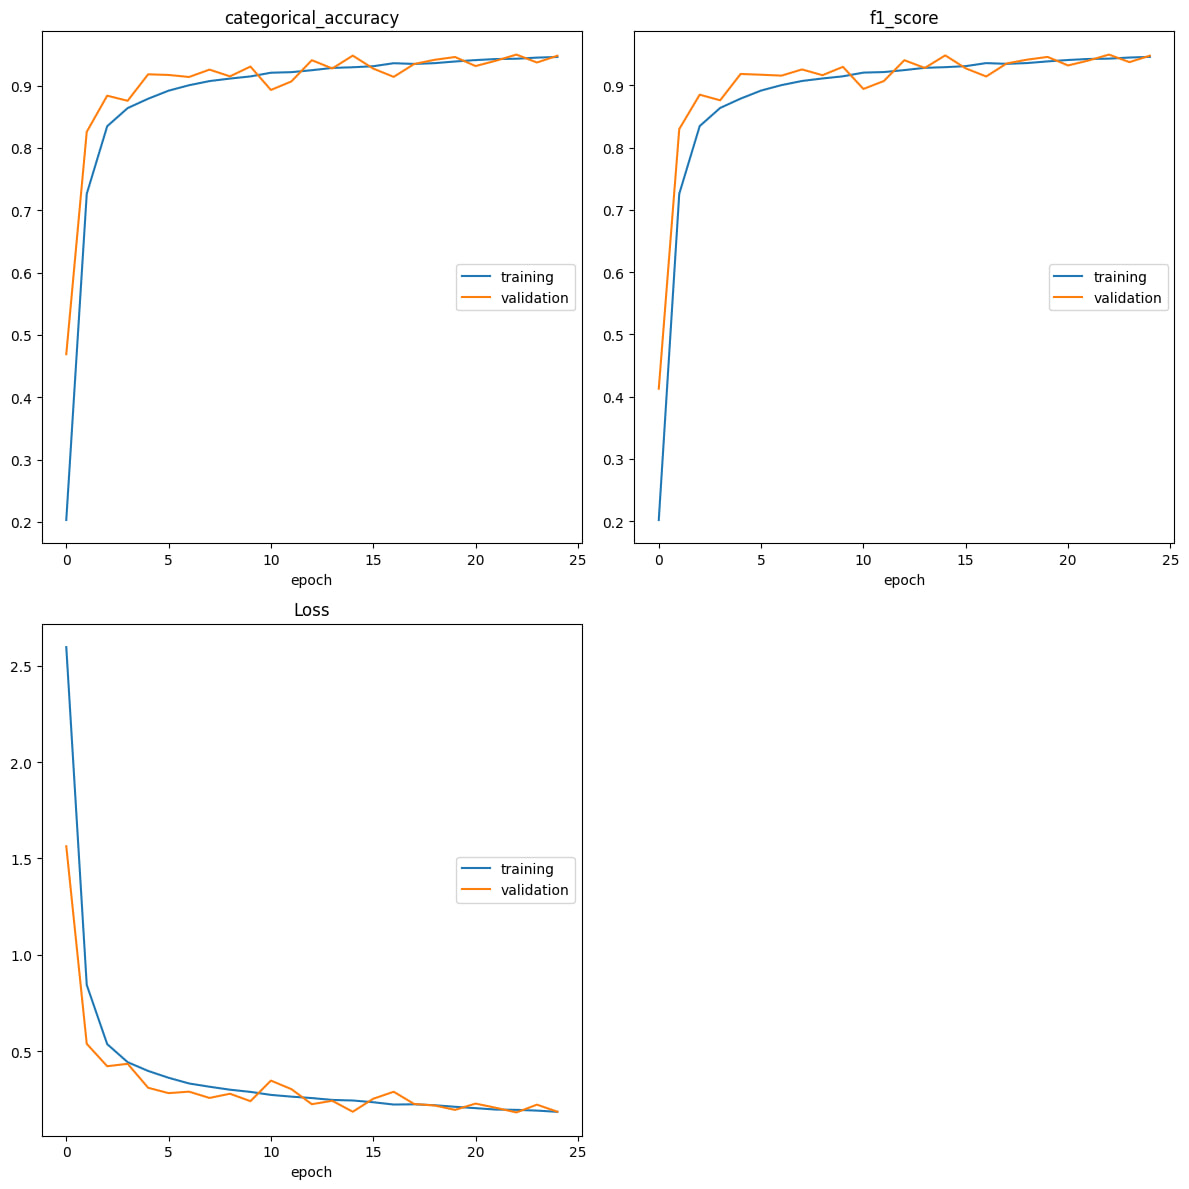

categorical_accuracy

  training            (min:    0.203, max:    0.946, cur:    0.946)

  validation          (min:    0.469, max:    0.950, cur:    0.948)

f1_score

  training            (min:    0.202, max:    0.946, cur:    0.946)

  validation          (min:    0.413, max:    0.949, cur:    0.948)

Loss

  training            (min:    0.186, max:    2.597, cur:    0.186)

  validation          (min:    0.182, max:    1.564, cur:    0.186)

In [ ]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Дообучаем модель

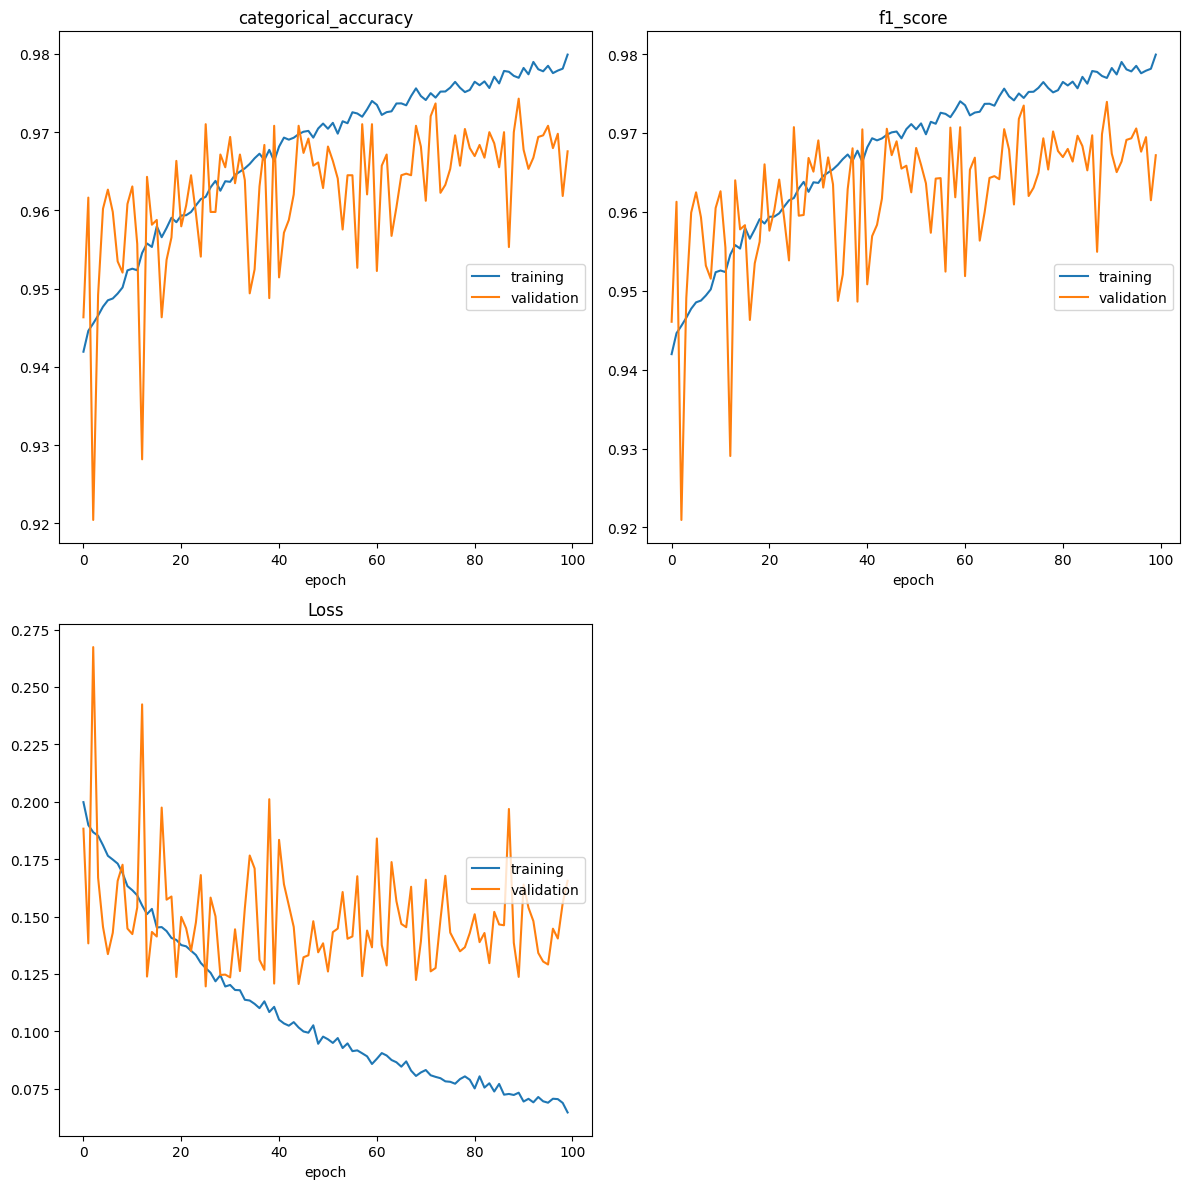

categorical_accuracy
	training         	 (min:    0.942, max:    0.980, cur:    0.980)
	validation       	 (min:    0.920, max:    0.974, cur:    0.968)
f1_score
	training         	 (min:    0.942, max:    0.980, cur:    0.980)
	validation       	 (min:    0.921, max:    0.974, cur:    0.967)
Loss
	training         	 (min:    0.065, max:    0.200, cur:    0.065)
	validation       	 (min:    0.120, max:    0.267, cur:    0.166)
651/651 [==============================] - 90s 139ms/step - loss: 0.0647 - categorical_accuracy: 0.9799 - f1_score: 0.9799 - val_loss: 0.1656 - val_categorical_accuracy: 0.9676 - val_f1_score: 0.9672


In [13]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

### 3.1.4 G24

In [ ]:
num_model = '_g_24'

In [21]:
def get_block(input_, filters, t, stride):
    in_ = input_.shape[-1]

    x = tf.keras.layers.Conv2D(in_ * t, 1, strides=1, padding='same', use_bias=False)(input_)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x)

    x = tf.keras.layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x)

    x = tf.keras.layers.Conv2D(filters, 1, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x if in_ != filters else tf.keras.layers.Add()([input_, x])


model_input = tf.keras.Input(shape=(32, 32, 3), batch_size=100)

x = tf.keras.layers.Conv2D(32, 3, strides=1, padding='same', use_bias=False)(model_input)

x = get_block(x, 16, 1, 1)

x = get_block(x, 24, 6, 1)
x = get_block(x, 24, 6, 1)

x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)
x = get_block(x, 32, 6, 1)

x = get_block(x, 64, 6, 2)
x = get_block(x, 64, 6, 1)
x = get_block(x, 64, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = get_block(x, 96, 6, 1)
x = get_block(x, 96, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = get_block(x, 160, 6, 2)
x = get_block(x, 160, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = get_block(x, 320, 6, 1)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(1280, 1, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU(6)(x)

x = tf.keras.layers.GlobalMaxPool2D()(x)
x = tf.keras.layers.Dense(10)(x)

model = tf.keras.models.Model(inputs=model_input, outputs=x)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(100, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d_99 (Conv2D)             (100, 32, 32, 32)    864         ['input_4[0][0]']                
                                                                                                  
 conv2d_100 (Conv2D)            (100, 32, 32, 32)    1024        ['conv2d_99[0][0]']              
                                                                                                  
 batch_normalization_125 (Batch  (100, 32, 32, 32)   128         ['conv2d_100[0][0]']             
 Normalization)                                                                             

In [ ]:
metrics, callbacks = get_metrics_and_callbacks(num_model)

In [ ]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(decay=1e-4)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100

651/651 [==============================] - 126s 167ms/step - loss: 2.0329 - 
categorical_accuracy: 0.3155 - f1_score: 0.3147 - val_loss: 0.8216 - 
val_categorical_accuracy: 0.7347 - val_f1_score: 0.7407

Epoch 2/100

651/651 [==============================] - 108s 165ms/step - loss: 0.5952 - 
categorical_accuracy: 0.8104 - f1_score: 0.8101 - val_loss: 0.3910 - 
val_categorical_accuracy: 0.8861 - val_f1_score: 0.8873

Epoch 3/100

651/651 [==============================] - 107s 165ms/step - loss: 0.4213 - 
categorical_accuracy: 0.8690 - f1_score: 0.8690 - val_loss: 0.2993 - 
val_categorical_accuracy: 0.9110 - val_f1_score: 0.9108

Epoch 4/100

651/651 [==============================] - 101s 155ms/step - loss: 0.3708 - 
categorical_accuracy: 0.8873 - f1_score: 0.8873 - val_loss: 0.3273 - 
val_categorical_accuracy: 0.9070 - val_f1_score: 0.9077

Epoch 5/100

651/651 [==============================] - 104s 160ms/step - loss: 0.3363 - 
categorical_accuracy: 0.8976 - f1_score: 0.8976 - val_loss: 0.3026 - 
val_categorical_accuracy: 0.9139 - val_f1_score: 0.9139

Epoch 6/100

651/651 [==============================] - 108s 165ms/step - loss: 0.3084 - 
categorical_accuracy: 0.9063 - f1_score: 0.9062 - val_loss: 0.2770 - 
val_categorical_accuracy: 0.9221 - val_f1_score: 0.9224

Epoch 7/100

651/651 [==============================] - 102s 157ms/step - loss: 0.2938 - 
categorical_accuracy: 0.9111 - f1_score: 0.9111 - val_loss: 0.2948 - 
val_categorical_accuracy: 0.9123 - val_f1_score: 0.9123

Epoch 8/100

651/651 [==============================] - 107s 165ms/step - loss: 0.2718 - 
categorical_accuracy: 0.9181 - f1_score: 0.9181 - val_loss: 0.2166 - 
val_categorical_accuracy: 0.9363 - val_f1_score: 0.9368

Epoch 9/100

651/651 [==============================] - 107s 165ms/step - loss: 0.2638 - 
categorical_accuracy: 0.9203 - f1_score: 0.9203 - val_loss: 0.2046 - 
val_categorical_accuracy: 0.9423 - val_f1_score: 0.9420

Epoch 10/100

651/651 [==============================] - 101s 155ms/step - loss: 0.2444 - 
categorical_accuracy: 0.9273 - f1_score: 0.9273 - val_loss: 0.2577 - 
val_categorical_accuracy: 0.9314 - val_f1_score: 0.9319

Epoch 11/100

651/651 [==============================] - 100s 153ms/step - loss: 0.2326 - 
categorical_accuracy: 0.9295 - f1_score: 0.9295 - val_loss: 0.2207 - 
val_categorical_accuracy: 0.9355 - val_f1_score: 0.9357

Epoch 12/100

651/651 [==============================] - 99s 152ms/step - loss: 0.2248 - 
categorical_accuracy: 0.9335 - f1_score: 0.9334 - val_loss: 0.2107 - 
val_categorical_accuracy: 0.9418 - val_f1_score: 0.9416

Epoch 13/100

651/651 [==============================] - 101s 155ms/step - loss: 0.2160 - 
categorical_accuracy: 0.9355 - f1_score: 0.9355 - val_loss: 0.2219 - 
val_categorical_accuracy: 0.9370 - val_f1_score: 0.9370

Epoch 14/100

651/651 [==============================] - 105s 162ms/step - loss: 0.2047 - 
categorical_accuracy: 0.9394 - f1_score: 0.9393 - val_loss: 0.1971 - 
val_categorical_accuracy: 0.9463 - val_f1_score: 0.9462

Epoch 15/100

651/651 [==============================] - 100s 153ms/step - loss: 0.1935 - 
categorical_accuracy: 0.9425 - f1_score: 0.9425 - val_loss: 0.2352 - 
val_categorical_accuracy: 0.9365 - val_f1_score: 0.9366

Epoch 16/100

651/651 [==============================] - 107s 164ms/step - loss: 0.1892 - 
categorical_accuracy: 0.9447 - f1_score: 0.9447 - val_loss: 0.1560 - 
val_categorical_accuracy: 0.9559 - val_f1_score: 0.9558

Epoch 17/100

651/651 [==============================] - 100s 153ms/step - loss: 0.1814 - 
categorical_accuracy: 0.9461 - f1_score: 0.9461 - val_loss: 0.1848 - 
val_categorical_accuracy: 0.9447 - val_f1_score: 0.9448

Epoch 18/100

651/651 [==============================] - 99s 152ms/step - loss: 0.1729 - 
categorical_accuracy: 0.9486 - f1_score: 0.9486 - val_loss: 0.1900 - 
val_categorical_accuracy: 0.9469 - val_f1_score: 0.9472

Epoch 19/100

651/651 [==============================] - 100s 154ms/step - loss: 0.1628 - 
categorical_accuracy: 0.9522 - f1_score: 0.9522 - val_loss: 0.1786 - 
val_categorical_accuracy: 0.9502 - val_f1_score: 0.9504

Epoch 20/100

651/651 [==============================] - 106s 163ms/step - loss: 0.1624 - 
categorical_accuracy: 0.9517 - f1_score: 0.9517 - val_loss: 0.1487 - 
val_categorical_accuracy: 0.9606 - val_f1_score: 0.9606

Epoch 21/100

651/651 [==============================] - 100s 153ms/step - loss: 0.1545 - 
categorical_accuracy: 0.9542 - f1_score: 0.9542 - val_loss: 0.1506 - 
val_categorical_accuracy: 0.9596 - val_f1_score: 0.9596

Epoch 22/100

651/651 [==============================] - 101s 155ms/step - loss: 0.1510 - 
categorical_accuracy: 0.9557 - f1_score: 0.9557 - val_loss: 0.1525 - 
val_categorical_accuracy: 0.9576 - val_f1_score: 0.9575

Epoch 23/100

651/651 [==============================] - 102s 156ms/step - loss: 0.1424 - 
categorical_accuracy: 0.9576 - f1_score: 0.9576 - val_loss: 0.1446 - 
val_categorical_accuracy: 0.9600 - val_f1_score: 0.9599

Epoch 24/100

651/651 [==============================] - 99s 152ms/step - loss: 0.1371 - 
categorical_accuracy: 0.9595 - f1_score: 0.9595 - val_loss: 0.1843 - 
val_categorical_accuracy: 0.9502 - val_f1_score: 0.9501

Epoch 25/100

651/651 [==============================] - 100s 154ms/step - loss: 0.1345 - 
categorical_accuracy: 0.9600 - f1_score: 0.9600 - val_loss: 0.1462 - 
val_categorical_accuracy: 0.9590 - val_f1_score: 0.9589

Epoch 26/100

651/651 [==============================] - 109s 167ms/step - loss: 0.1293 - 
categorical_accuracy: 0.9616 - f1_score: 0.9616 - val_loss: 0.1266 - 
val_categorical_accuracy: 0.9655 - val_f1_score: 0.9655

Epoch 27/100

651/651 [==============================] - 101s 154ms/step - loss: 0.1236 - 
categorical_accuracy: 0.9630 - f1_score: 0.9630 - val_loss: 0.1380 - 
val_categorical_accuracy: 0.9633 - val_f1_score: 0.9632

Epoch 28/100

651/651 [==============================] - 100s 153ms/step - loss: 0.1248 - 
categorical_accuracy: 0.9634 - f1_score: 0.9634 - val_loss: 0.1429 - 
val_categorical_accuracy: 0.9631 - val_f1_score: 0.9630

Epoch 29/100

651/651 [==============================] - 102s 156ms/step - loss: 0.1144 - 
categorical_accuracy: 0.9652 - f1_score: 0.9652 - val_loss: 0.1398 - 
val_categorical_accuracy: 0.9639 - val_f1_score: 0.9639

Epoch 30/100

651/651 [==============================] - 100s 153ms/step - loss: 0.1127 - 
categorical_accuracy: 0.9666 - f1_score: 0.9666 - val_loss: 0.1383 - 
val_categorical_accuracy: 0.9627 - val_f1_score: 0.9626

Epoch 31/100

651/651 [==============================] - 105s 162ms/step - loss: 0.1119 - 
categorical_accuracy: 0.9665 - f1_score: 0.9664 - val_loss: 0.1301 - 
val_categorical_accuracy: 0.9665 - val_f1_score: 0.9665

Epoch 32/100

651/651 [==============================] - 102s 156ms/step - loss: 0.1043 - 
categorical_accuracy: 0.9689 - f1_score: 0.9689 - val_loss: 0.1507 - 
val_categorical_accuracy: 0.9594 - val_f1_score: 0.9595

Epoch 33/100

651/651 [==============================] - 102s 157ms/step - loss: 0.1039 - 
categorical_accuracy: 0.9687 - f1_score: 0.9687 - val_loss: 0.1246 - 
val_categorical_accuracy: 0.9639 - val_f1_score: 0.9639

Epoch 34/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0994 - 
categorical_accuracy: 0.9701 - f1_score: 0.9701 - val_loss: 0.1316 - 
val_categorical_accuracy: 0.9649 - val_f1_score: 0.9649

Epoch 35/100

651/651 [==============================] - 104s 160ms/step - loss: 0.0986 - 
categorical_accuracy: 0.9705 - f1_score: 0.9705 - val_loss: 0.1304 - 
val_categorical_accuracy: 0.9676 - val_f1_score: 0.9675

Epoch 36/100

651/651 [==============================] - 109s 167ms/step - loss: 0.0927 - 
categorical_accuracy: 0.9718 - f1_score: 0.9718 - val_loss: 0.1192 - 
val_categorical_accuracy: 0.9680 - val_f1_score: 0.9679

Epoch 37/100

651/651 [==============================] - 106s 163ms/step - loss: 0.0909 - 
categorical_accuracy: 0.9720 - f1_score: 0.9720 - val_loss: 0.1241 - 
val_categorical_accuracy: 0.9700 - val_f1_score: 0.9701

Epoch 38/100

651/651 [==============================] - 109s 167ms/step - loss: 0.0889 - 
categorical_accuracy: 0.9725 - f1_score: 0.9725 - val_loss: 0.1189 - 
val_categorical_accuracy: 0.9718 - val_f1_score: 0.9717

Epoch 39/100

651/651 [==============================] - 105s 162ms/step - loss: 0.0862 - 
categorical_accuracy: 0.9737 - f1_score: 0.9737 - val_loss: 0.1148 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9706

Epoch 40/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0830 - 
categorical_accuracy: 0.9748 - f1_score: 0.9748 - val_loss: 0.1259 - 
val_categorical_accuracy: 0.9694 - val_f1_score: 0.9694

Epoch 41/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0819 - 
categorical_accuracy: 0.9752 - f1_score: 0.9752 - val_loss: 0.1331 - 
val_categorical_accuracy: 0.9678 - val_f1_score: 0.9676

Epoch 42/100

651/651 [==============================] - 101s 156ms/step - loss: 0.0780 - 
categorical_accuracy: 0.9754 - f1_score: 0.9754 - val_loss: 0.1310 - 
val_categorical_accuracy: 0.9661 - val_f1_score: 0.9660

Epoch 43/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0766 - 
categorical_accuracy: 0.9764 - f1_score: 0.9764 - val_loss: 0.1287 - 
val_categorical_accuracy: 0.9651 - val_f1_score: 0.9651

Epoch 44/100

651/651 [==============================] - 102s 156ms/step - loss: 0.0753 - 
categorical_accuracy: 0.9763 - f1_score: 0.9762 - val_loss: 0.1204 - 
val_categorical_accuracy: 0.9710 - val_f1_score: 0.9709

Epoch 45/100

651/651 [==============================] - 103s 159ms/step - loss: 0.0732 - 
categorical_accuracy: 0.9771 - f1_score: 0.9771 - val_loss: 0.1261 - 
val_categorical_accuracy: 0.9700 - val_f1_score: 0.9700

Epoch 46/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0688 - 
categorical_accuracy: 0.9784 - f1_score: 0.9784 - val_loss: 0.1269 - 
val_categorical_accuracy: 0.9698 - val_f1_score: 0.9697

Epoch 47/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0688 - 
categorical_accuracy: 0.9784 - f1_score: 0.9784 - val_loss: 0.1464 - 
val_categorical_accuracy: 0.9659 - val_f1_score: 0.9661

Epoch 48/100

651/651 [==============================] - 108s 166ms/step - loss: 0.0651 - 
categorical_accuracy: 0.9800 - f1_score: 0.9800 - val_loss: 0.1139 - 
val_categorical_accuracy: 0.9735 - val_f1_score: 0.9735

Epoch 49/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0666 - 
categorical_accuracy: 0.9782 - f1_score: 0.9782 - val_loss: 0.1158 - 
val_categorical_accuracy: 0.9716 - val_f1_score: 0.9716

Epoch 50/100

651/651 [==============================] - 101s 154ms/step - loss: 0.0624 - 
categorical_accuracy: 0.9805 - f1_score: 0.9805 - val_loss: 0.1353 - 
val_categorical_accuracy: 0.9667 - val_f1_score: 0.9667

Epoch 51/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0618 - 
categorical_accuracy: 0.9810 - f1_score: 0.9810 - val_loss: 0.1280 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9708

Epoch 52/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0602 - 
categorical_accuracy: 0.9804 - f1_score: 0.9804 - val_loss: 0.1145 - 
val_categorical_accuracy: 0.9710 - val_f1_score: 0.9711

Epoch 53/100

651/651 [==============================] - 107s 165ms/step - loss: 0.0567 - 
categorical_accuracy: 0.9818 - f1_score: 0.9818 - val_loss: 0.1139 - 
val_categorical_accuracy: 0.9743 - val_f1_score: 0.9743

Epoch 54/100

651/651 [==============================] - 104s 159ms/step - loss: 0.0568 - 
categorical_accuracy: 0.9825 - f1_score: 0.9825 - val_loss: 0.1138 - 
val_categorical_accuracy: 0.9735 - val_f1_score: 0.9735

Epoch 55/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0530 - 
categorical_accuracy: 0.9826 - f1_score: 0.9826 - val_loss: 0.1264 - 
val_categorical_accuracy: 0.9720 - val_f1_score: 0.9721

Epoch 56/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0550 - 
categorical_accuracy: 0.9824 - f1_score: 0.9824 - val_loss: 0.1153 - 
val_categorical_accuracy: 0.9725 - val_f1_score: 0.9724

Epoch 57/100

651/651 [==============================] - 107s 165ms/step - loss: 0.0542 - 
categorical_accuracy: 0.9825 - f1_score: 0.9825 - val_loss: 0.1126 - 
val_categorical_accuracy: 0.9749 - val_f1_score: 0.9749

Epoch 58/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0537 - 
categorical_accuracy: 0.9829 - f1_score: 0.9829 - val_loss: 0.1298 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9707

Epoch 59/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0494 - 
categorical_accuracy: 0.9848 - f1_score: 0.9848 - val_loss: 0.1273 - 
val_categorical_accuracy: 0.9725 - val_f1_score: 0.9724

Epoch 60/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0488 - 
categorical_accuracy: 0.9841 - f1_score: 0.9841 - val_loss: 0.1293 - 
val_categorical_accuracy: 0.9710 - val_f1_score: 0.9711

Epoch 61/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0493 - 
categorical_accuracy: 0.9843 - f1_score: 0.9843 - val_loss: 0.1138 - 
val_categorical_accuracy: 0.9739 - val_f1_score: 0.9738

Epoch 62/100

651/651 [==============================] - 106s 162ms/step - loss: 0.0473 - 
categorical_accuracy: 0.9847 - f1_score: 0.9847 - val_loss: 0.1203 - 
val_categorical_accuracy: 0.9751 - val_f1_score: 0.9751

Epoch 63/100

651/651 [==============================] - 101s 156ms/step - loss: 0.0474 - 
categorical_accuracy: 0.9845 - f1_score: 0.9845 - val_loss: 0.1162 - 
val_categorical_accuracy: 0.9749 - val_f1_score: 0.9750

Epoch 64/100

651/651 [==============================] - 101s 154ms/step - loss: 0.0449 - 
categorical_accuracy: 0.9858 - f1_score: 0.9858 - val_loss: 0.1161 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9737

Epoch 65/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0461 - 
categorical_accuracy: 0.9849 - f1_score: 0.9849 - val_loss: 0.1172 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9738

Epoch 66/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0431 - 
categorical_accuracy: 0.9858 - f1_score: 0.9858 - val_loss: 0.1287 - 
val_categorical_accuracy: 0.9714 - val_f1_score: 0.9715

Epoch 67/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0412 - 
categorical_accuracy: 0.9867 - f1_score: 0.9867 - val_loss: 0.1159 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9747

Epoch 68/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0398 - 
categorical_accuracy: 0.9873 - f1_score: 0.9873 - val_loss: 0.1268 - 
val_categorical_accuracy: 0.9733 - val_f1_score: 0.9732

Epoch 69/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0396 - 
categorical_accuracy: 0.9867 - f1_score: 0.9867 - val_loss: 0.1320 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9707

Epoch 70/100

651/651 [==============================] - 106s 162ms/step - loss: 0.0390 - 
categorical_accuracy: 0.9871 - f1_score: 0.9870 - val_loss: 0.1174 - 
val_categorical_accuracy: 0.9757 - val_f1_score: 0.9758

Epoch 71/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0390 - 
categorical_accuracy: 0.9867 - f1_score: 0.9867 - val_loss: 0.1199 - 
val_categorical_accuracy: 0.9749 - val_f1_score: 0.9749

Epoch 72/100

651/651 [==============================] - 101s 154ms/step - loss: 0.0379 - 
categorical_accuracy: 0.9874 - f1_score: 0.9874 - val_loss: 0.1145 - 
val_categorical_accuracy: 0.9745 - val_f1_score: 0.9746

Epoch 73/100

651/651 [==============================] - 103s 158ms/step - loss: 0.0365 - 
categorical_accuracy: 0.9878 - f1_score: 0.9878 - val_loss: 0.1122 - 
val_categorical_accuracy: 0.9757 - val_f1_score: 0.9758

Epoch 74/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0351 - 
categorical_accuracy: 0.9887 - f1_score: 0.9887 - val_loss: 0.1253 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9747

Epoch 75/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0354 - 
categorical_accuracy: 0.9881 - f1_score: 0.9881 - val_loss: 0.1230 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9748

Epoch 76/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0350 - 
categorical_accuracy: 0.9887 - f1_score: 0.9887 - val_loss: 0.1229 - 
val_categorical_accuracy: 0.9757 - val_f1_score: 0.9757

Epoch 77/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0338 - 
categorical_accuracy: 0.9887 - f1_score: 0.9887 - val_loss: 0.1224 - 
val_categorical_accuracy: 0.9743 - val_f1_score: 0.9742

Epoch 78/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0335 - 
categorical_accuracy: 0.9887 - f1_score: 0.9887 - val_loss: 0.1189 - 
val_categorical_accuracy: 0.9749 - val_f1_score: 0.9749

Epoch 79/100

651/651 [==============================] - 101s 154ms/step - loss: 0.0307 - 
categorical_accuracy: 0.9896 - f1_score: 0.9896 - val_loss: 0.1297 - 
val_categorical_accuracy: 0.9755 - val_f1_score: 0.9754

Epoch 80/100

651/651 [==============================] - 105s 162ms/step - loss: 0.0334 - 
categorical_accuracy: 0.9885 - f1_score: 0.9885 - val_loss: 0.1233 - 
val_categorical_accuracy: 0.9767 - val_f1_score: 0.9767

Epoch 81/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0316 - 
categorical_accuracy: 0.9895 - f1_score: 0.9895 - val_loss: 0.1256 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9764

Epoch 82/100

651/651 [==============================] - 101s 156ms/step - loss: 0.0308 - 
categorical_accuracy: 0.9897 - f1_score: 0.9897 - val_loss: 0.1190 - 
val_categorical_accuracy: 0.9741 - val_f1_score: 0.9742

Epoch 83/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0322 - 
categorical_accuracy: 0.9892 - f1_score: 0.9892 - val_loss: 0.1222 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9737

Epoch 84/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0286 - 
categorical_accuracy: 0.9906 - f1_score: 0.9906 - val_loss: 0.1192 - 
val_categorical_accuracy: 0.9749 - val_f1_score: 0.9749

Epoch 85/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0295 - 
categorical_accuracy: 0.9902 - f1_score: 0.9902 - val_loss: 0.1183 - 
val_categorical_accuracy: 0.9741 - val_f1_score: 0.9741

Epoch 86/100

651/651 [==============================] - 102s 157ms/step - loss: 0.0281 - 
categorical_accuracy: 0.9908 - f1_score: 0.9908 - val_loss: 0.1275 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9736

Epoch 87/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0282 - 
categorical_accuracy: 0.9910 - f1_score: 0.9910 - val_loss: 0.1241 - 
val_categorical_accuracy: 0.9761 - val_f1_score: 0.9761

Epoch 88/100

651/651 [==============================] - 105s 161ms/step - loss: 0.0300 - 
categorical_accuracy: 0.9899 - f1_score: 0.9899 - val_loss: 0.1191 - 
val_categorical_accuracy: 0.9774 - val_f1_score: 0.9773

Epoch 89/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0271 - 
categorical_accuracy: 0.9910 - f1_score: 0.9910 - val_loss: 0.1194 - 
val_categorical_accuracy: 0.9755 - val_f1_score: 0.9755

Epoch 90/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0261 - 
categorical_accuracy: 0.9915 - f1_score: 0.9915 - val_loss: 0.1213 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9747

Epoch 91/100

651/651 [==============================] - 105s 162ms/step - loss: 0.0254 - 
categorical_accuracy: 0.9918 - f1_score: 0.9918 - val_loss: 0.1169 - 
val_categorical_accuracy: 0.9782 - val_f1_score: 0.9782

Epoch 92/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0269 - 
categorical_accuracy: 0.9909 - f1_score: 0.9909 - val_loss: 0.1188 - 
val_categorical_accuracy: 0.9774 - val_f1_score: 0.9773

Epoch 93/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0245 - 
categorical_accuracy: 0.9916 - f1_score: 0.9916 - val_loss: 0.1253 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9764

Epoch 94/100

651/651 [==============================] - 101s 156ms/step - loss: 0.0266 - 
categorical_accuracy: 0.9914 - f1_score: 0.9914 - val_loss: 0.1232 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9763

Epoch 95/100

651/651 [==============================] - 101s 156ms/step - loss: 0.0245 - 
categorical_accuracy: 0.9922 - f1_score: 0.9922 - val_loss: 0.1307 - 
val_categorical_accuracy: 0.9757 - val_f1_score: 0.9758

Epoch 96/100

651/651 [==============================] - 102s 157ms/step - loss: 0.0237 - 
categorical_accuracy: 0.9923 - f1_score: 0.9923 - val_loss: 0.1711 - 
val_categorical_accuracy: 0.9643 - val_f1_score: 0.9643

Epoch 97/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0247 - 
categorical_accuracy: 0.9918 - f1_score: 0.9917 - val_loss: 0.1359 - 
val_categorical_accuracy: 0.9771 - val_f1_score: 0.9771

Epoch 98/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0246 - 
categorical_accuracy: 0.9920 - f1_score: 0.9919 - val_loss: 0.1281 - 
val_categorical_accuracy: 0.9739 - val_f1_score: 0.9739

Epoch 99/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0248 - 
categorical_accuracy: 0.9915 - f1_score: 0.9915 - val_loss: 0.1197 - 
val_categorical_accuracy: 0.9765 - val_f1_score: 0.9765

Epoch 100/100

651/651 [==============================] - 106s 163ms/step - loss: 0.0238 - 
categorical_accuracy: 0.9921 - f1_score: 0.9921 - val_loss: 0.1167 - 
val_categorical_accuracy: 0.9790 - val_f1_score: 0.9790

### 3.1.5 G22

In [ ]:
num_model = '_g_22'

In [22]:
def tree(x, filters, kernel_size, strides=1, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)


inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (5, 5), padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
fork = tf.keras.layers.ReLU()(x)


tree1 = tree(fork, 16, 1, strides=1)
tree2 = tree(fork, 16, 3, strides=1)
tree3 = tree(fork, 16, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(16, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 32, 1, strides=1)
tree2 = tree(fork, 32, 3, strides=1)
tree3 = tree(fork, 32, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(23, 1, padding='same', activation='relu')(tree4)
fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])


tree1 = tree(fork, 48, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])

tree1 = tree(fork, 48, 1, strides=1)
tree2 = tree(fork, 48, 3, strides=1)
tree3 = tree(fork, 48, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(48, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 64, 1, strides=1)
tree2 = tree(fork, 64, 3, strides=1)
tree3 = tree(fork, 64, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(64, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 80, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])

tree1 = tree(fork, 80, 1, strides=1)
tree2 = tree(fork, 80, 3, strides=1)
tree3 = tree(fork, 80, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(80, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 96, 1, strides=1)
tree2 = tree(fork, 96, 3, strides=1)
tree3 = tree(fork, 96, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(96, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

x = tf.keras.layers.GlobalAveragePooling2D()(fork)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_129 (Conv2D)            (None, 32, 32, 32)   2432        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_168 (Batch  (None, 32, 32, 32)  128         ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_120 (ReLU)               (None, 32, 32, 32)   0           ['batch_normalization_168[0

In [ ]:
metrics, callbacks = get_metrics_and_callbacks(num_model)


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.008)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

In [ ]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.0013, decay=0.002)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100

651/651 [==============================] - 167s 162ms/step - loss: 0.8946 - 
categorical_accuracy: 0.6957 - f1_score: 0.6954 - val_loss: 0.5987 - 
val_categorical_accuracy: 0.8155 - val_f1_score: 0.8200 - lr: 0.0016

Epoch 2/100

651/651 [==============================] - 105s 161ms/step - loss: 0.3155 - 
categorical_accuracy: 0.9039 - f1_score: 0.9039 - val_loss: 0.5028 - 
val_categorical_accuracy: 0.8494 - val_f1_score: 0.8586 - lr: 0.0016

Epoch 3/100

651/651 [==============================] - 103s 159ms/step - loss: 0.2596 - 
categorical_accuracy: 0.9234 - f1_score: 0.9234 - val_loss: 0.2797 - 
val_categorical_accuracy: 0.9243 - val_f1_score: 0.9243 - lr: 0.0016

Epoch 4/100

651/651 [==============================] - 105s 162ms/step - loss: 0.2313 - 
categorical_accuracy: 0.9304 - f1_score: 0.9304 - val_loss: 0.2453 - 
val_categorical_accuracy: 0.9331 - val_f1_score: 0.9335 - lr: 0.0016

Epoch 5/100

651/651 [==============================] - 97s 148ms/step - loss: 0.2098 - 
categorical_accuracy: 0.9380 - f1_score: 0.9380 - val_loss: 0.3263 - 
val_categorical_accuracy: 0.9059 - val_f1_score: 0.9067 - lr: 0.0016

Epoch 6/100

651/651 [==============================] - 98s 151ms/step - loss: 0.1935 - 
categorical_accuracy: 0.9425 - f1_score: 0.9425 - val_loss: 0.2420 - 
val_categorical_accuracy: 0.9229 - val_f1_score: 0.9245 - lr: 0.0016

Epoch 7/100

651/651 [==============================] - 96s 147ms/step - loss: 0.1805 - 
categorical_accuracy: 0.9460 - f1_score: 0.9460 - val_loss: 0.2497 - 
val_categorical_accuracy: 0.9267 - val_f1_score: 0.9293 - lr: 0.0016

Epoch 8/100

651/651 [==============================] - 96s 147ms/step - loss: 0.1701 - 
categorical_accuracy: 0.9497 - f1_score: 0.9497 - val_loss: 0.2746 - 
val_categorical_accuracy: 0.9251 - val_f1_score: 0.9251 - lr: 0.0016

Epoch 9/100

651/651 [==============================] - 97s 149ms/step - loss: 0.1616 - 
categorical_accuracy: 0.9520 - f1_score: 0.9520 - val_loss: 0.2905 - 
val_categorical_accuracy: 0.9206 - val_f1_score: 0.9216 - lr: 0.0016

Epoch 10/100

651/651 [==============================] - 105s 161ms/step - loss: 0.1509 - 
categorical_accuracy: 0.9547 - f1_score: 0.9547 - val_loss: 0.2328 - 
val_categorical_accuracy: 0.9414 - val_f1_score: 0.9423 - lr: 0.0016

Epoch 11/100

651/651 [==============================] - 97s 150ms/step - loss: 0.1409 - 
categorical_accuracy: 0.9581 - f1_score: 0.9581 - val_loss: 0.2524 - 
val_categorical_accuracy: 0.9331 - val_f1_score: 0.9330 - lr: 0.0016

Epoch 12/100

651/651 [==============================] - 101s 155ms/step - loss: 0.1326 - 
categorical_accuracy: 0.9604 - f1_score: 0.9604 - val_loss: 0.2233 - 
val_categorical_accuracy: 0.9427 - val_f1_score: 0.9421 - lr: 0.0015

Epoch 13/100

651/651 [==============================] - 99s 151ms/step - loss: 0.1207 - 
categorical_accuracy: 0.9643 - f1_score: 0.9643 - val_loss: 0.2119 - 
val_categorical_accuracy: 0.9404 - val_f1_score: 0.9413 - lr: 0.0015

Epoch 14/100

651/651 [==============================] - 105s 160ms/step - loss: 0.1116 - 
categorical_accuracy: 0.9663 - f1_score: 0.9663 - val_loss: 0.1736 - 
val_categorical_accuracy: 0.9614 - val_f1_score: 0.9615 - lr: 0.0014

Epoch 15/100

651/651 [==============================] - 97s 149ms/step - loss: 0.1090 - 
categorical_accuracy: 0.9673 - f1_score: 0.9673 - val_loss: 0.2020 - 
val_categorical_accuracy: 0.9518 - val_f1_score: 0.9516 - lr: 0.0014

Epoch 16/100

651/651 [==============================] - 103s 158ms/step - loss: 0.0984 - 
categorical_accuracy: 0.9710 - f1_score: 0.9710 - val_loss: 0.1441 - 
val_categorical_accuracy: 0.9637 - val_f1_score: 0.9635 - lr: 0.0013

Epoch 17/100

651/651 [==============================] - 97s 149ms/step - loss: 0.0947 - 
categorical_accuracy: 0.9715 - f1_score: 0.9715 - val_loss: 0.2316 - 
val_categorical_accuracy: 0.9474 - val_f1_score: 0.9471 - lr: 0.0013

Epoch 18/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0839 - 
categorical_accuracy: 0.9749 - f1_score: 0.9749 - val_loss: 0.1862 - 
val_categorical_accuracy: 0.9549 - val_f1_score: 0.9546 - lr: 0.0013

Epoch 19/100

651/651 [==============================] - 97s 149ms/step - loss: 0.0822 - 
categorical_accuracy: 0.9750 - f1_score: 0.9750 - val_loss: 0.1613 - 
val_categorical_accuracy: 0.9612 - val_f1_score: 0.9611 - lr: 0.0012

Epoch 20/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0753 - 
categorical_accuracy: 0.9767 - f1_score: 0.9767 - val_loss: 0.1726 - 
val_categorical_accuracy: 0.9572 - val_f1_score: 0.9572 - lr: 0.0012

Epoch 21/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0718 - 
categorical_accuracy: 0.9776 - f1_score: 0.9776 - val_loss: 0.1742 - 
val_categorical_accuracy: 0.9631 - val_f1_score: 0.9630 - lr: 0.0012

Epoch 22/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0656 - 
categorical_accuracy: 0.9799 - f1_score: 0.9799 - val_loss: 0.1966 - 
val_categorical_accuracy: 0.9541 - val_f1_score: 0.9542 - lr: 0.0011

Epoch 23/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0623 - 
categorical_accuracy: 0.9807 - f1_score: 0.9807 - val_loss: 0.1667 - 
val_categorical_accuracy: 0.9637 - val_f1_score: 0.9637 - lr: 0.0011

Epoch 24/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0583 - 
categorical_accuracy: 0.9820 - f1_score: 0.9820 - val_loss: 0.1978 - 
val_categorical_accuracy: 0.9567 - val_f1_score: 0.9573 - lr: 0.0011

Epoch 25/100

651/651 [==============================] - 97s 149ms/step - loss: 0.0542 - 
categorical_accuracy: 0.9829 - f1_score: 0.9829 - val_loss: 0.1798 - 
val_categorical_accuracy: 0.9580 - val_f1_score: 0.9578 - lr: 0.0010

Epoch 26/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0572 - 
categorical_accuracy: 0.9818 - f1_score: 0.9818 - val_loss: 0.1581 - 
val_categorical_accuracy: 0.9637 - val_f1_score: 0.9637 - lr: 9.9005e-04

Epoch 27/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0495 - 
categorical_accuracy: 0.9844 - f1_score: 0.9844 - val_loss: 0.1944 - 
val_categorical_accuracy: 0.9563 - val_f1_score: 0.9563 - lr: 9.6079e-04

Epoch 28/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0477 - 
categorical_accuracy: 0.9846 - f1_score: 0.9846 - val_loss: 0.1643 - 
val_categorical_accuracy: 0.9608 - val_f1_score: 0.9608 - lr: 9.3240e-04

Epoch 29/100

651/651 [==============================] - 101s 154ms/step - loss: 0.0417 - 
categorical_accuracy: 0.9865 - f1_score: 0.9865 - val_loss: 0.1621 - 
val_categorical_accuracy: 0.9639 - val_f1_score: 0.9639 - lr: 9.0484e-04

Epoch 30/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0391 - 
categorical_accuracy: 0.9874 - f1_score: 0.9874 - val_loss: 0.1600 - 
val_categorical_accuracy: 0.9718 - val_f1_score: 0.9718 - lr: 8.7810e-04

Epoch 31/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0398 - 
categorical_accuracy: 0.9873 - f1_score: 0.9873 - val_loss: 0.1633 - 
val_categorical_accuracy: 0.9688 - val_f1_score: 0.9687 - lr: 8.5215e-04

Epoch 32/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0356 - 
categorical_accuracy: 0.9881 - f1_score: 0.9881 - val_loss: 0.2129 - 
val_categorical_accuracy: 0.9590 - val_f1_score: 0.9593 - lr: 8.2696e-04

Epoch 33/100

651/651 [==============================] - 97s 149ms/step - loss: 0.0358 - 
categorical_accuracy: 0.9883 - f1_score: 0.9883 - val_loss: 0.1836 - 
val_categorical_accuracy: 0.9671 - val_f1_score: 0.9672 - lr: 8.0252e-04

Epoch 34/100

651/651 [==============================] - 95s 147ms/step - loss: 0.0336 - 
categorical_accuracy: 0.9888 - f1_score: 0.9888 - val_loss: 0.2342 - 
val_categorical_accuracy: 0.9567 - val_f1_score: 0.9567 - lr: 7.7880e-04

Epoch 35/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0308 - 
categorical_accuracy: 0.9900 - f1_score: 0.9900 - val_loss: 0.1843 - 
val_categorical_accuracy: 0.9645 - val_f1_score: 0.9644 - lr: 7.5579e-04

Epoch 36/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0305 - 
categorical_accuracy: 0.9903 - f1_score: 0.9903 - val_loss: 0.1610 - 
val_categorical_accuracy: 0.9667 - val_f1_score: 0.9665 - lr: 7.3345e-04

Epoch 37/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0296 - 
categorical_accuracy: 0.9906 - f1_score: 0.9906 - val_loss: 0.1884 - 
val_categorical_accuracy: 0.9647 - val_f1_score: 0.9646 - lr: 7.1177e-04

Epoch 38/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0263 - 
categorical_accuracy: 0.9912 - f1_score: 0.9912 - val_loss: 0.2117 - 
val_categorical_accuracy: 0.9633 - val_f1_score: 0.9633 - lr: 6.9074e-04

Epoch 39/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0270 - 
categorical_accuracy: 0.9910 - f1_score: 0.9910 - val_loss: 0.1954 - 
val_categorical_accuracy: 0.9712 - val_f1_score: 0.9711 - lr: 6.7032e-04

Epoch 40/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0227 - 
categorical_accuracy: 0.9920 - f1_score: 0.9920 - val_loss: 0.1839 - 
val_categorical_accuracy: 0.9702 - val_f1_score: 0.9702 - lr: 6.5051e-04

Epoch 41/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0225 - 
categorical_accuracy: 0.9922 - f1_score: 0.9922 - val_loss: 0.1900 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9705 - lr: 6.3129e-04

Epoch 42/100

651/651 [==============================] - 94s 144ms/step - loss: 0.0238 - 
categorical_accuracy: 0.9919 - f1_score: 0.9919 - val_loss: 0.1894 - 
val_categorical_accuracy: 0.9674 - val_f1_score: 0.9673 - lr: 6.1263e-04

Epoch 43/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0223 - 
categorical_accuracy: 0.9926 - f1_score: 0.9926 - val_loss: 0.1780 - 
val_categorical_accuracy: 0.9706 - val_f1_score: 0.9707 - lr: 5.9452e-04

Epoch 44/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0189 - 
categorical_accuracy: 0.9938 - f1_score: 0.9938 - val_loss: 0.1957 - 
val_categorical_accuracy: 0.9702 - val_f1_score: 0.9701 - lr: 5.7695e-04

Epoch 45/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0203 - 
categorical_accuracy: 0.9934 - f1_score: 0.9934 - val_loss: 0.1961 - 
val_categorical_accuracy: 0.9714 - val_f1_score: 0.9714 - lr: 5.5990e-04

Epoch 46/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0188 - 
categorical_accuracy: 0.9939 - f1_score: 0.9939 - val_loss: 0.1892 - 
val_categorical_accuracy: 0.9700 - val_f1_score: 0.9698 - lr: 5.4335e-04

Epoch 47/100

651/651 [==============================] - 99s 152ms/step - loss: 0.0171 - 
categorical_accuracy: 0.9940 - f1_score: 0.9940 - val_loss: 0.1786 - 
val_categorical_accuracy: 0.9733 - val_f1_score: 0.9732 - lr: 5.2730e-04

Epoch 48/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0181 - 
categorical_accuracy: 0.9940 - f1_score: 0.9940 - val_loss: 0.1895 - 
val_categorical_accuracy: 0.9712 - val_f1_score: 0.9712 - lr: 5.1171e-04

Epoch 49/100

651/651 [==============================] - 96s 148ms/step - loss: 0.0174 - 
categorical_accuracy: 0.9944 - f1_score: 0.9944 - val_loss: 0.1944 - 
val_categorical_accuracy: 0.9674 - val_f1_score: 0.9673 - lr: 4.9659e-04

Epoch 50/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0160 - 
categorical_accuracy: 0.9950 - f1_score: 0.9950 - val_loss: 0.1773 - 
val_categorical_accuracy: 0.9712 - val_f1_score: 0.9712 - lr: 4.8191e-04

Epoch 51/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0152 - 
categorical_accuracy: 0.9950 - f1_score: 0.9950 - val_loss: 0.1878 - 
val_categorical_accuracy: 0.9708 - val_f1_score: 0.9708 - lr: 4.6767e-04

Epoch 52/100

651/651 [==============================] - 102s 156ms/step - loss: 0.0150 - 
categorical_accuracy: 0.9947 - f1_score: 0.9947 - val_loss: 0.1950 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9736 - lr: 4.5385e-04

Epoch 53/100

651/651 [==============================] - 97s 149ms/step - loss: 0.0141 - 
categorical_accuracy: 0.9952 - f1_score: 0.9952 - val_loss: 0.1929 - 
val_categorical_accuracy: 0.9729 - val_f1_score: 0.9727 - lr: 4.4043e-04

Epoch 54/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0137 - 
categorical_accuracy: 0.9957 - f1_score: 0.9957 - val_loss: 0.2190 - 
val_categorical_accuracy: 0.9680 - val_f1_score: 0.9679 - lr: 4.2742e-04

Epoch 55/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0140 - 
categorical_accuracy: 0.9954 - f1_score: 0.9954 - val_loss: 0.1998 - 
val_categorical_accuracy: 0.9714 - val_f1_score: 0.9713 - lr: 4.1479e-04

Epoch 56/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0127 - 
categorical_accuracy: 0.9956 - f1_score: 0.9956 - val_loss: 0.1766 - 
val_categorical_accuracy: 0.9755 - val_f1_score: 0.9754 - lr: 4.0253e-04

Epoch 57/100

651/651 [==============================] - 95s 145ms/step - loss: 0.0116 - 
categorical_accuracy: 0.9963 - f1_score: 0.9963 - val_loss: 0.1966 - 
val_categorical_accuracy: 0.9712 - val_f1_score: 0.9711 - lr: 3.9063e-04

Epoch 58/100

651/651 [==============================] - 95s 146ms/step - loss: 0.0119 - 
categorical_accuracy: 0.9959 - f1_score: 0.9959 - val_loss: 0.1966 - 
val_categorical_accuracy: 0.9727 - val_f1_score: 0.9726 - lr: 3.7909e-04

Epoch 59/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0126 - 
categorical_accuracy: 0.9959 - f1_score: 0.9959 - val_loss: 0.2020 - 
val_categorical_accuracy: 0.9725 - val_f1_score: 0.9724 - lr: 3.6788e-04

Epoch 60/100

651/651 [==============================] - 95s 147ms/step - loss: 0.0122 - 
categorical_accuracy: 0.9959 - f1_score: 0.9959 - val_loss: 0.1886 - 
val_categorical_accuracy: 0.9751 - val_f1_score: 0.9750 - lr: 3.5701e-04

Epoch 61/100

651/651 [==============================] - 95s 145ms/step - loss: 0.0096 - 
categorical_accuracy: 0.9967 - f1_score: 0.9967 - val_loss: 0.1832 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9746 - lr: 3.4646e-04

Epoch 62/100

651/651 [==============================] - 95s 147ms/step - loss: 0.0107 - 
categorical_accuracy: 0.9964 - f1_score: 0.9964 - val_loss: 0.2032 - 
val_categorical_accuracy: 0.9735 - val_f1_score: 0.9734 - lr: 3.3622e-04

Epoch 63/100

651/651 [==============================] - 100s 153ms/step - loss: 0.0117 - 
categorical_accuracy: 0.9962 - f1_score: 0.9962 - val_loss: 0.1760 - 
val_categorical_accuracy: 0.9759 - val_f1_score: 0.9758 - lr: 3.2628e-04

Epoch 64/100

651/651 [==============================] - 99s 152ms/step - loss: 0.0100 - 
categorical_accuracy: 0.9967 - f1_score: 0.9967 - val_loss: 0.1959 - 
val_categorical_accuracy: 0.9745 - val_f1_score: 0.9743 - lr: 3.1664e-04

Epoch 65/100

651/651 [==============================] - 103s 158ms/step - loss: 0.0094 - 
categorical_accuracy: 0.9970 - f1_score: 0.9970 - val_loss: 0.1878 - 
val_categorical_accuracy: 0.9745 - val_f1_score: 0.9744 - lr: 3.0728e-04

Epoch 66/100

651/651 [==============================] - 104s 160ms/step - loss: 0.0096 - 
categorical_accuracy: 0.9969 - f1_score: 0.9969 - val_loss: 0.1952 - 
val_categorical_accuracy: 0.9749 - val_f1_score: 0.9748 - lr: 2.9820e-04

Epoch 67/100

651/651 [==============================] - 102s 156ms/step - loss: 0.0100 - 
categorical_accuracy: 0.9967 - f1_score: 0.9967 - val_loss: 0.1928 - 
val_categorical_accuracy: 0.9745 - val_f1_score: 0.9743 - lr: 2.8939e-04

Epoch 68/100

651/651 [==============================] - 102s 157ms/step - loss: 0.0095 - 
categorical_accuracy: 0.9969 - f1_score: 0.9969 - val_loss: 0.2158 - 
val_categorical_accuracy: 0.9710 - val_f1_score: 0.9710 - lr: 2.8083e-04

Epoch 69/100

651/651 [==============================] - 102s 157ms/step - loss: 0.0079 - 
categorical_accuracy: 0.9973 - f1_score: 0.9973 - val_loss: 0.1869 - 
val_categorical_accuracy: 0.9741 - val_f1_score: 0.9740 - lr: 2.7253e-04

Epoch 70/100

651/651 [==============================] - 109s 167ms/step - loss: 0.0075 - 
categorical_accuracy: 0.9974 - f1_score: 0.9974 - val_loss: 0.1883 - 
val_categorical_accuracy: 0.9761 - val_f1_score: 0.9760 - lr: 2.6448e-04

Epoch 71/100

651/651 [==============================] - 106s 163ms/step - loss: 0.0080 - 
categorical_accuracy: 0.9976 - f1_score: 0.9976 - val_loss: 0.2217 - 
val_categorical_accuracy: 0.9678 - val_f1_score: 0.9677 - lr: 2.5666e-04

Epoch 72/100

651/651 [==============================] - 106s 162ms/step - loss: 0.0076 - 
categorical_accuracy: 0.9975 - f1_score: 0.9975 - val_loss: 0.2008 - 
val_categorical_accuracy: 0.9731 - val_f1_score: 0.9729 - lr: 2.4908e-04

Epoch 73/100

651/651 [==============================] - 107s 165ms/step - loss: 0.0084 - 
categorical_accuracy: 0.9974 - f1_score: 0.9974 - val_loss: 0.2019 - 
val_categorical_accuracy: 0.9747 - val_f1_score: 0.9746 - lr: 2.4172e-04

Epoch 74/100

651/651 [==============================] - 104s 160ms/step - loss: 0.0079 - 
categorical_accuracy: 0.9972 - f1_score: 0.9972 - val_loss: 0.2045 - 
val_categorical_accuracy: 0.9737 - val_f1_score: 0.9736 - lr: 2.3457e-04

Epoch 75/100

651/651 [==============================] - 99s 152ms/step - loss: 0.0075 - 
categorical_accuracy: 0.9975 - f1_score: 0.9975 - val_loss: 0.1964 - 
val_categorical_accuracy: 0.9757 - val_f1_score: 0.9757 - lr: 2.2764e-04

Epoch 76/100

651/651 [==============================] - 104s 159ms/step - loss: 0.0079 - 
categorical_accuracy: 0.9973 - f1_score: 0.9973 - val_loss: 0.1929 - 
val_categorical_accuracy: 0.9769 - val_f1_score: 0.9769 - lr: 2.2091e-04

Epoch 77/100

651/651 [==============================] - 106s 162ms/step - loss: 0.0068 - 
categorical_accuracy: 0.9977 - f1_score: 0.9977 - val_loss: 0.1834 - 
val_categorical_accuracy: 0.9757 - val_f1_score: 0.9756 - lr: 2.1438e-04

Epoch 78/100

651/651 [==============================] - 107s 165ms/step - loss: 0.0061 - 
categorical_accuracy: 0.9983 - f1_score: 0.9983 - val_loss: 0.1871 - 
val_categorical_accuracy: 0.9765 - val_f1_score: 0.9765 - lr: 2.0805e-04

Epoch 79/100

651/651 [==============================] - 112s 172ms/step - loss: 0.0062 - 
categorical_accuracy: 0.9980 - f1_score: 0.9980 - val_loss: 0.1951 - 
val_categorical_accuracy: 0.9751 - val_f1_score: 0.9750 - lr: 2.0190e-04

Epoch 80/100

651/651 [==============================] - 107s 164ms/step - loss: 0.0067 - 
categorical_accuracy: 0.9979 - f1_score: 0.9979 - val_loss: 0.1953 - 
val_categorical_accuracy: 0.9761 - val_f1_score: 0.9760 - lr: 1.9593e-04

Epoch 81/100

651/651 [==============================] - 106s 163ms/step - loss: 0.0060 - 
categorical_accuracy: 0.9982 - f1_score: 0.9982 - val_loss: 0.1941 - 
val_categorical_accuracy: 0.9755 - val_f1_score: 0.9754 - lr: 1.9014e-04

Epoch 82/100

651/651 [==============================] - 105s 161ms/step - loss: 0.0058 - 
categorical_accuracy: 0.9981 - f1_score: 0.9981 - val_loss: 0.1994 - 
val_categorical_accuracy: 0.9767 - val_f1_score: 0.9767 - lr: 1.8452e-04

Epoch 83/100

651/651 [==============================] - 104s 160ms/step - loss: 0.0053 - 
categorical_accuracy: 0.9981 - f1_score: 0.9981 - val_loss: 0.1940 - 
val_categorical_accuracy: 0.9761 - val_f1_score: 0.9760 - lr: 1.7907e-04

Epoch 84/100

651/651 [==============================] - 104s 160ms/step - loss: 0.0055 - 
categorical_accuracy: 0.9982 - f1_score: 0.9982 - val_loss: 0.1893 - 
val_categorical_accuracy: 0.9767 - val_f1_score: 0.9766 - lr: 1.7378e-04

Epoch 85/100

651/651 [==============================] - 105s 161ms/step - loss: 0.0056 - 
categorical_accuracy: 0.9983 - f1_score: 0.9983 - val_loss: 0.1942 - 
val_categorical_accuracy: 0.9759 - val_f1_score: 0.9758 - lr: 1.6864e-04

Epoch 86/100

651/651 [==============================] - 106s 163ms/step - loss: 0.0053 - 
categorical_accuracy: 0.9982 - f1_score: 0.9982 - val_loss: 0.1934 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9763 - lr: 1.6366e-04

Epoch 87/100

651/651 [==============================] - 106s 163ms/step - loss: 0.0058 - 
categorical_accuracy: 0.9978 - f1_score: 0.9978 - val_loss: 0.1923 - 
val_categorical_accuracy: 0.9753 - val_f1_score: 0.9752 - lr: 1.5882e-04

Epoch 88/100

651/651 [==============================] - 107s 165ms/step - loss: 0.0056 - 
categorical_accuracy: 0.9981 - f1_score: 0.9981 - val_loss: 0.1884 - 
val_categorical_accuracy: 0.9761 - val_f1_score: 0.9760 - lr: 1.5412e-04

Epoch 89/100

651/651 [==============================] - 108s 166ms/step - loss: 0.0050 - 
categorical_accuracy: 0.9982 - f1_score: 0.9982 - val_loss: 0.1876 - 
val_categorical_accuracy: 0.9771 - val_f1_score: 0.9770 - lr: 1.4957e-04

Epoch 90/100

651/651 [==============================] - 98s 151ms/step - loss: 0.0043 - 
categorical_accuracy: 0.9988 - f1_score: 0.9988 - val_loss: 0.1889 - 
val_categorical_accuracy: 0.9759 - val_f1_score: 0.9758 - lr: 1.4515e-04

Epoch 91/100

651/651 [==============================] - 98s 150ms/step - loss: 0.0050 - 
categorical_accuracy: 0.9985 - f1_score: 0.9985 - val_loss: 0.2005 - 
val_categorical_accuracy: 0.9769 - val_f1_score: 0.9768 - lr: 1.4086e-04

Epoch 92/100

651/651 [==============================] - 100s 154ms/step - loss: 0.0047 - 
categorical_accuracy: 0.9986 - f1_score: 0.9986 - val_loss: 0.2038 - 
val_categorical_accuracy: 0.9771 - val_f1_score: 0.9771 - lr: 1.3670e-04

Epoch 93/100

651/651 [==============================] - 101s 155ms/step - loss: 0.0054 - 
categorical_accuracy: 0.9983 - f1_score: 0.9983 - val_loss: 0.1949 - 
val_categorical_accuracy: 0.9786 - val_f1_score: 0.9785 - lr: 1.3266e-04

Epoch 94/100

651/651 [==============================] - 98s 151ms/step - loss: 0.0045 - 
categorical_accuracy: 0.9983 - f1_score: 0.9983 - val_loss: 0.1918 - 
val_categorical_accuracy: 0.9765 - val_f1_score: 0.9765 - lr: 1.2874e-04

Epoch 95/100

651/651 [==============================] - 96s 147ms/step - loss: 0.0047 - 
categorical_accuracy: 0.9987 - f1_score: 0.9987 - val_loss: 0.1886 - 
val_categorical_accuracy: 0.9780 - val_f1_score: 0.9779 - lr: 1.2493e-04

Epoch 96/100

651/651 [==============================] - 95s 145ms/step - loss: 0.0044 - 
categorical_accuracy: 0.9985 - f1_score: 0.9985 - val_loss: 0.1935 - 
val_categorical_accuracy: 0.9767 - val_f1_score: 0.9767 - lr: 1.2124e-04

Epoch 97/100

651/651 [==============================] - 97s 149ms/step - loss: 0.0041 - 
categorical_accuracy: 0.9986 - f1_score: 0.9986 - val_loss: 0.1998 - 
val_categorical_accuracy: 0.9751 - val_f1_score: 0.9750 - lr: 1.1766e-04

Epoch 98/100

651/651 [==============================] - 97s 149ms/step - loss: 0.0045 - 
categorical_accuracy: 0.9987 - f1_score: 0.9987 - val_loss: 0.1928 - 
val_categorical_accuracy: 0.9763 - val_f1_score: 0.9762 - lr: 1.1418e-04

Epoch 99/100

651/651 [==============================] - 95s 147ms/step - loss: 0.0046 - 
categorical_accuracy: 0.9985 - f1_score: 0.9985 - val_loss: 0.1915 - 
val_categorical_accuracy: 0.9767 - val_f1_score: 0.9766 - lr: 1.1080e-04

Epoch 100/100

651/651 [==============================] - 101s 156ms/step - loss: 0.0045 - 
categorical_accuracy: 0.9985 - f1_score: 0.9985 - val_loss: 0.1864 - 
val_categorical_accuracy: 0.9802 - val_f1_score: 0.9801 - lr: 1.0753e-04

----
# У нас получилось 5 очень сильных моделей. Которые мы объединили в ансамбле bagging. 

In [35]:
pred_s6 = pickle.load(open('checkpoint_answers/model_s_6_avg_categorical_accuracy.h5', 'rb'))
pred_g21 = pickle.load(open('checkpoint_answers/model_g_21_avg_categorical_accuracy.h5', 'rb'))
pred_g17 = pickle.load(open('checkpoint_answers/model_g_17_avg_categorical_accuracy.h5', 'rb'))
pred_g24 = pickle.load(open('checkpoint_answers/model_g_24_avg_categorical_accuracy.h5', 'rb'))
pred_g22 = pickle.load(open('checkpoint_answers/model_g_22_avg_categorical_accuracy.h5', 'rb'))

In [36]:
ans = np.argmax(pred_s6 + pred_g21 + pred_g11 + pred_g24 + pred_g22 + pred_g17, axis=-1)

In [37]:
ensemble_model_name = 'y_pred'
ans = pd.DataFrame({'Id': np.arange(ans.shape[0]), 'Category': ans})
ans.to_csv(f'{ensemble_model_name}.csv', index=False)

- приватный - 0.96548
- публичный - 0.96813

----
----
# ВЫВОД:
#### Мы добились поставленных целей: изучили основные аспекты computer-vision, а именно классификацию изображений, получили ценный опыт совместной работы и представления о отрасли машинного обучения в целом. Из прошедшей работы можно сделать заключение о том, что важнейшим фактором в проектной деятельности является командная работа. Без эффективного распределения работы и взаимодействия, огромные усилия могут уйти впустую и , напротив, малые силы в правильном месте и под правильным управлением могут достичь многого. Так и во всём в жизни суету легче преодолевать вместе.